/tmp/ipykernel_8103/466579382.py:179: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 6, figsize=(15, 6))


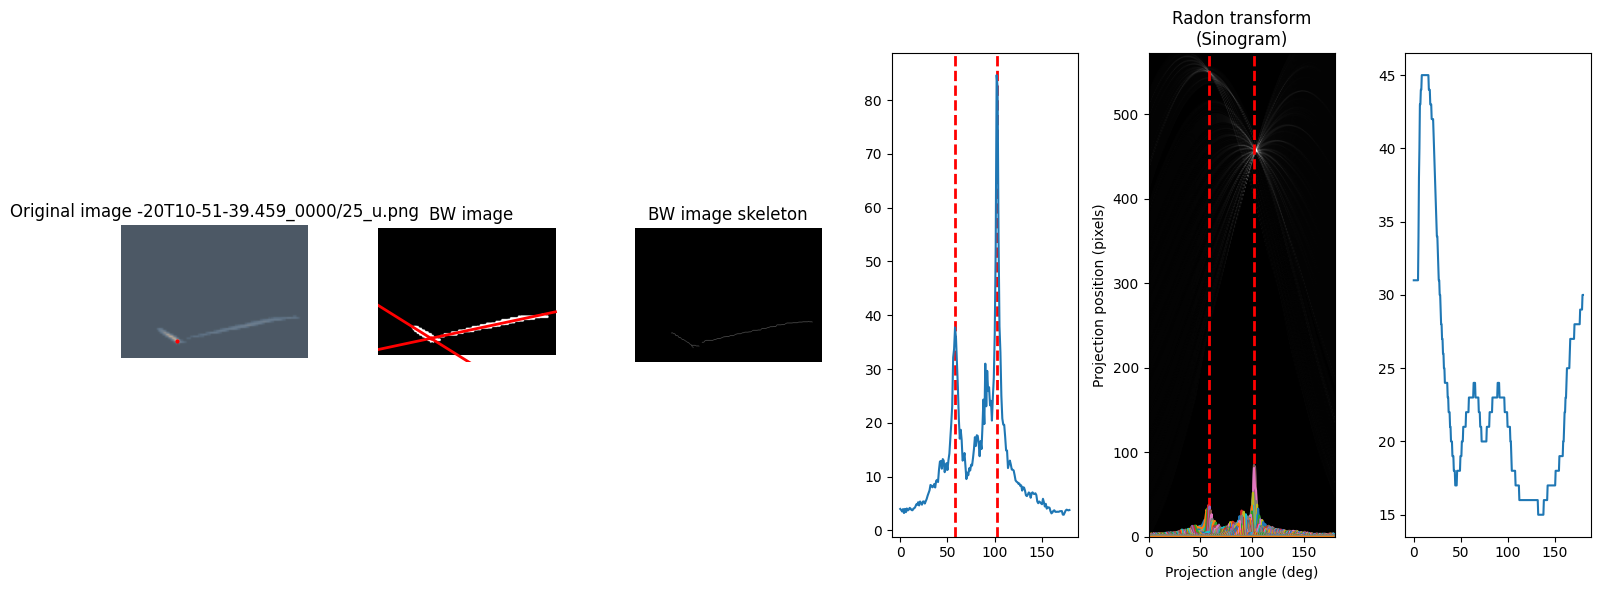

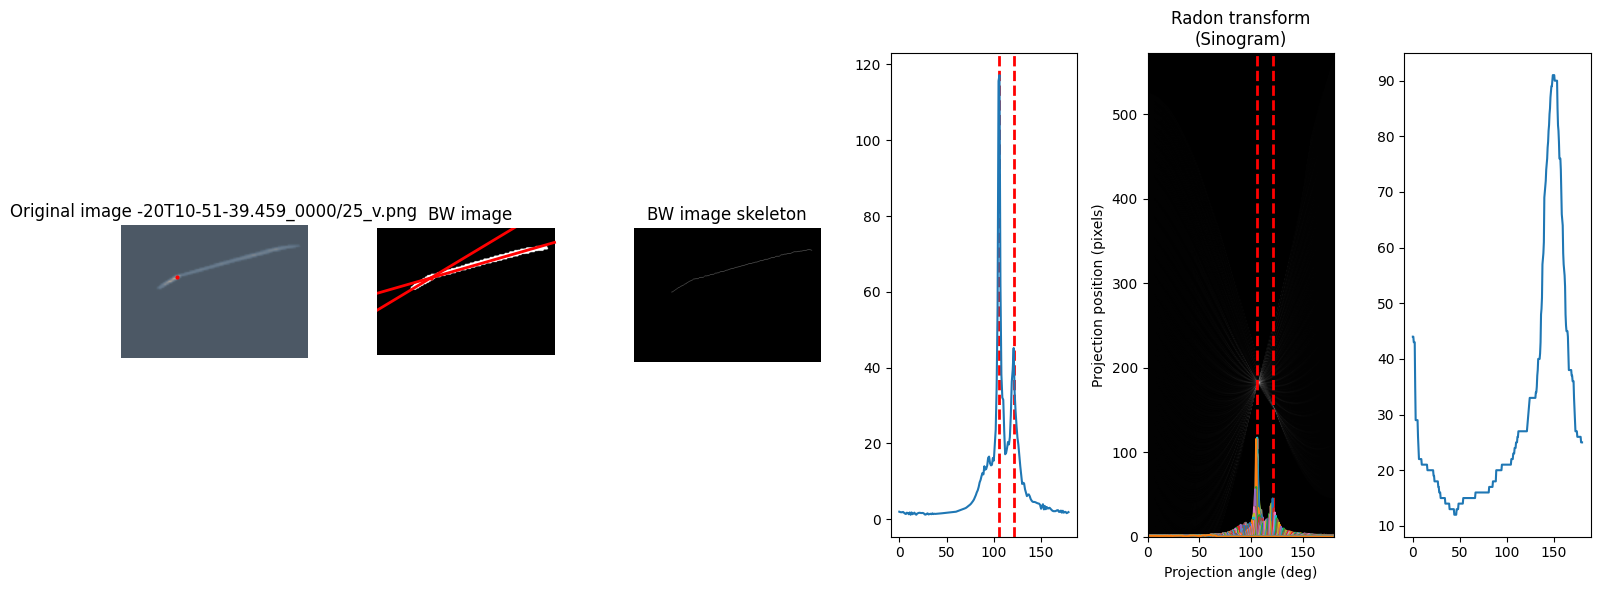

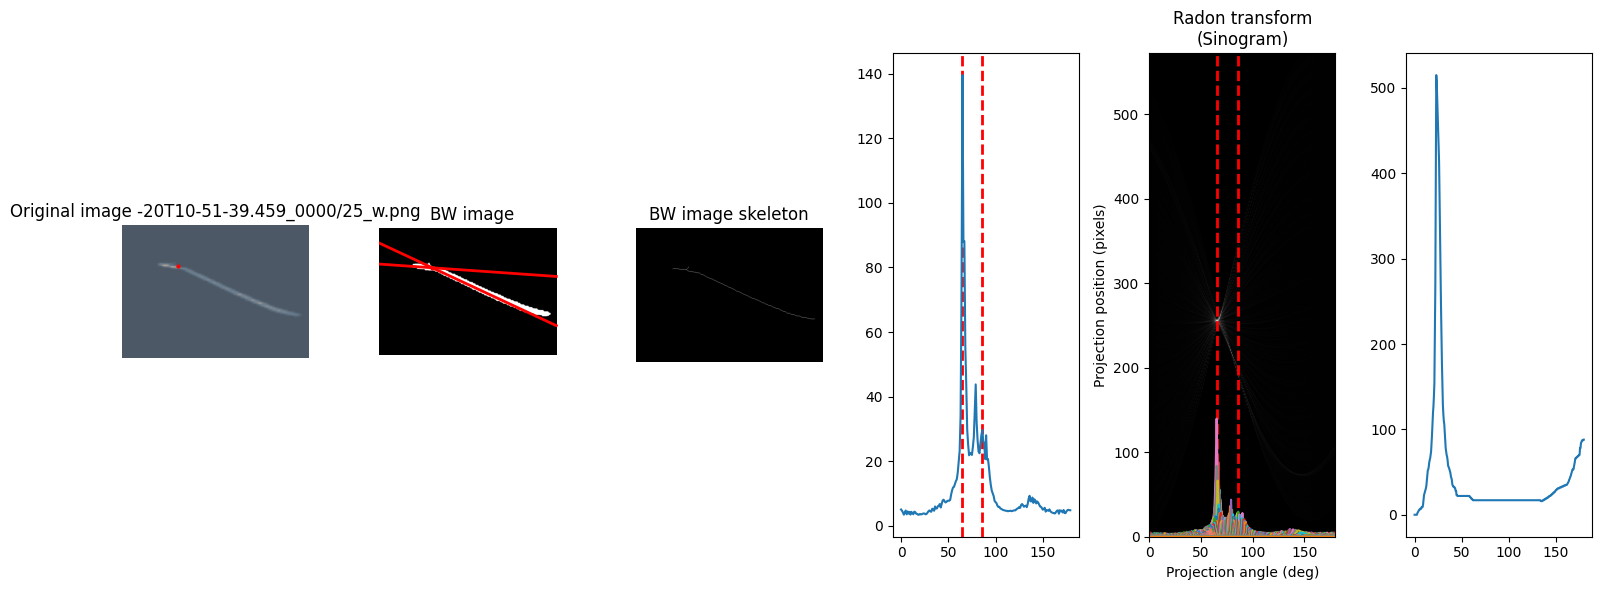

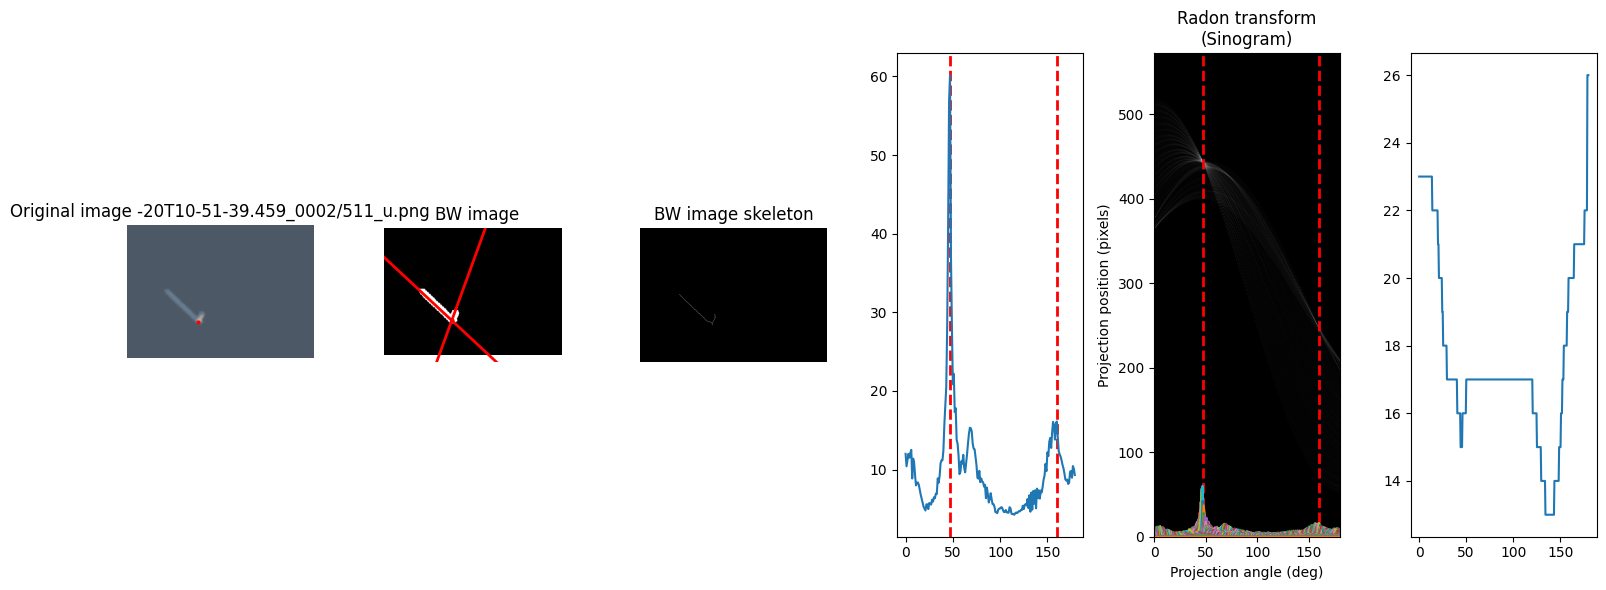

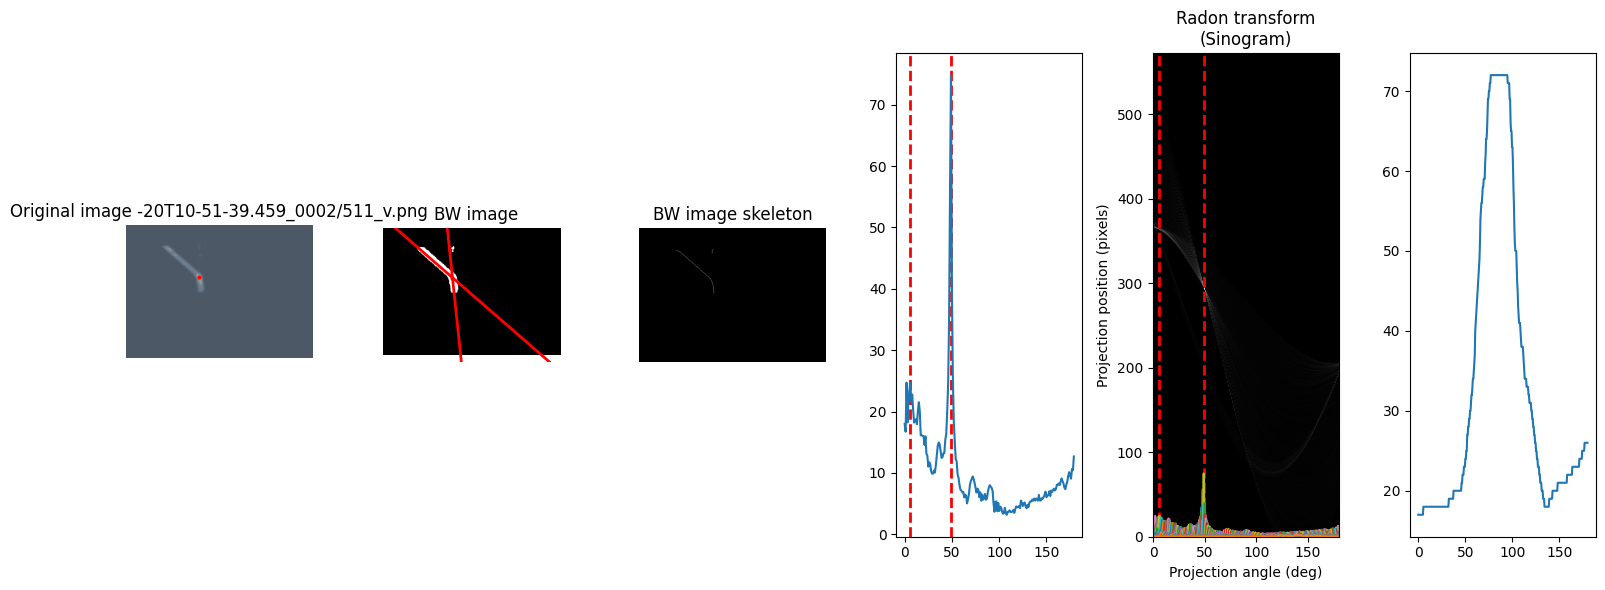

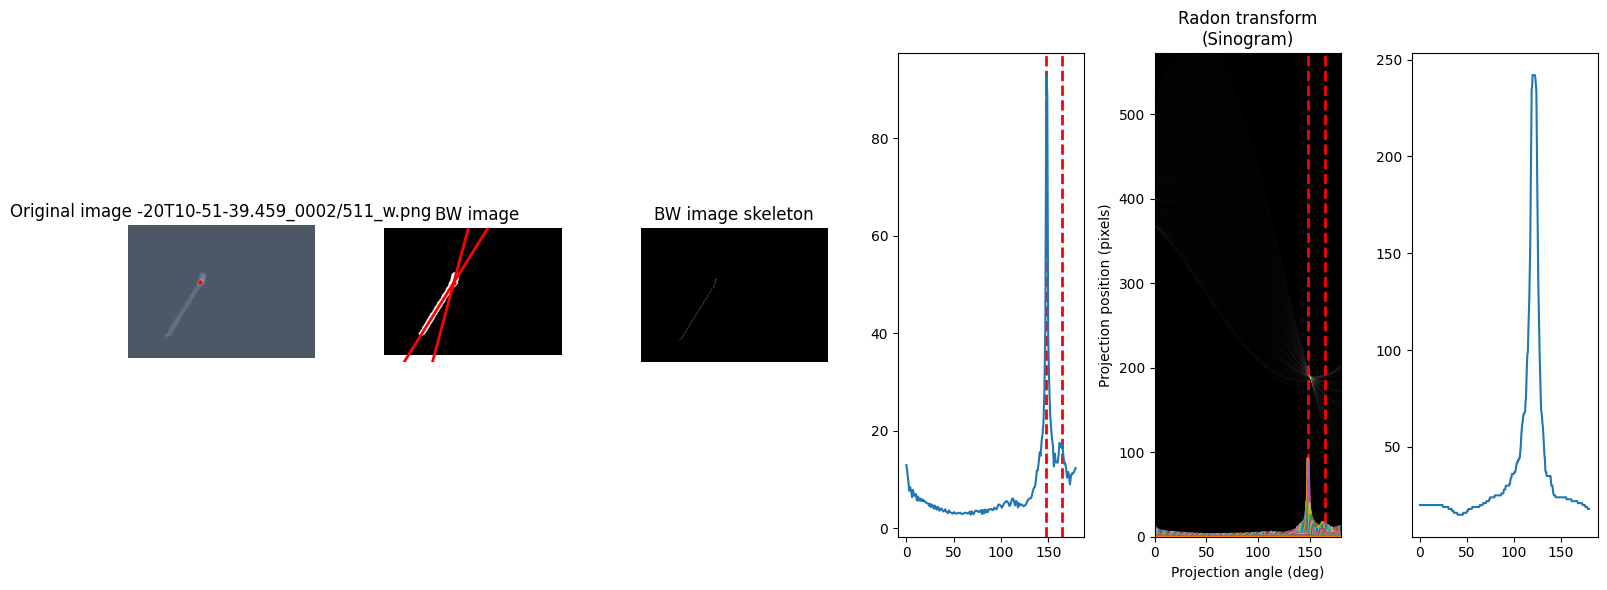

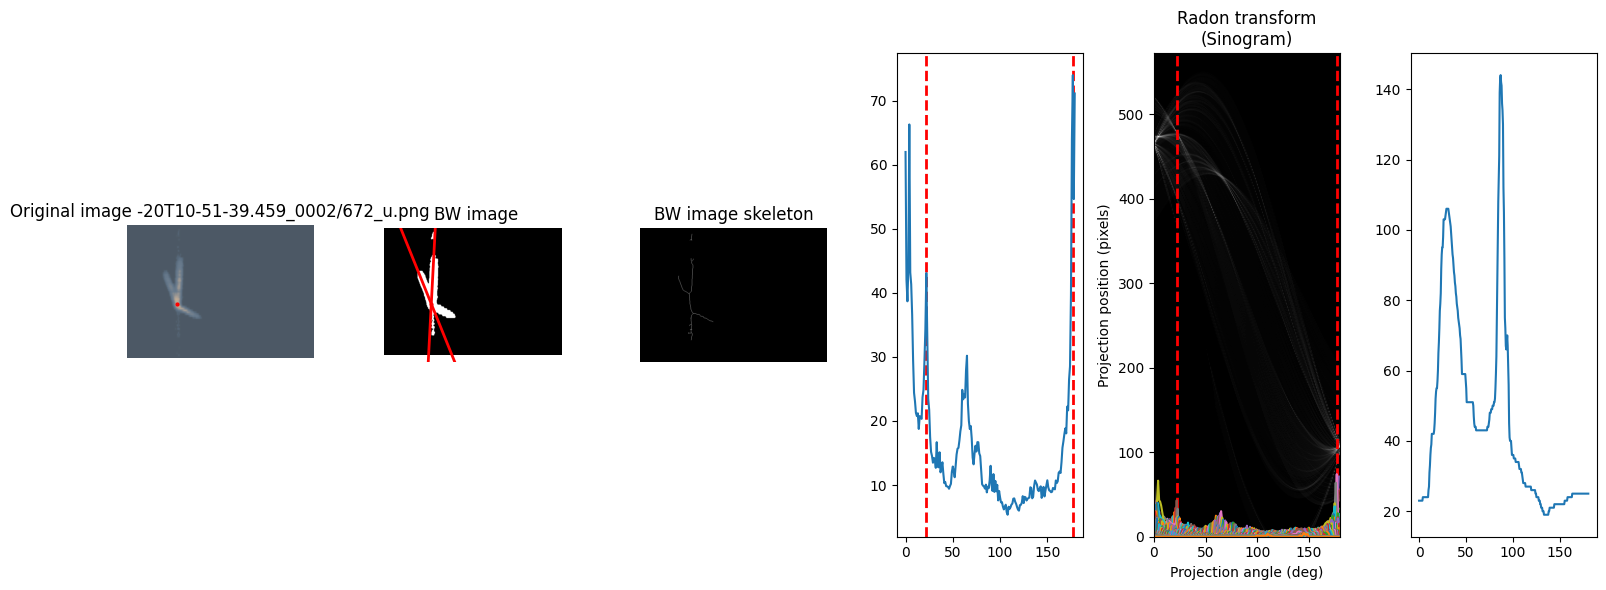

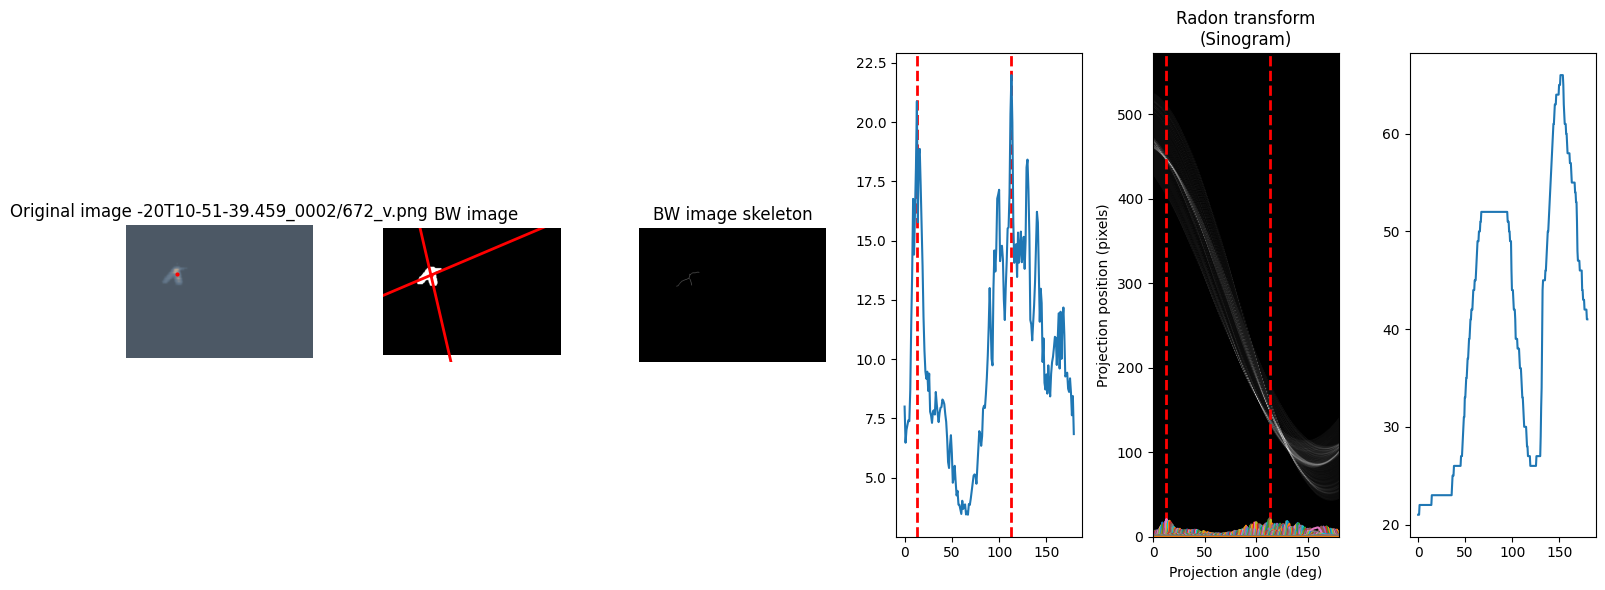

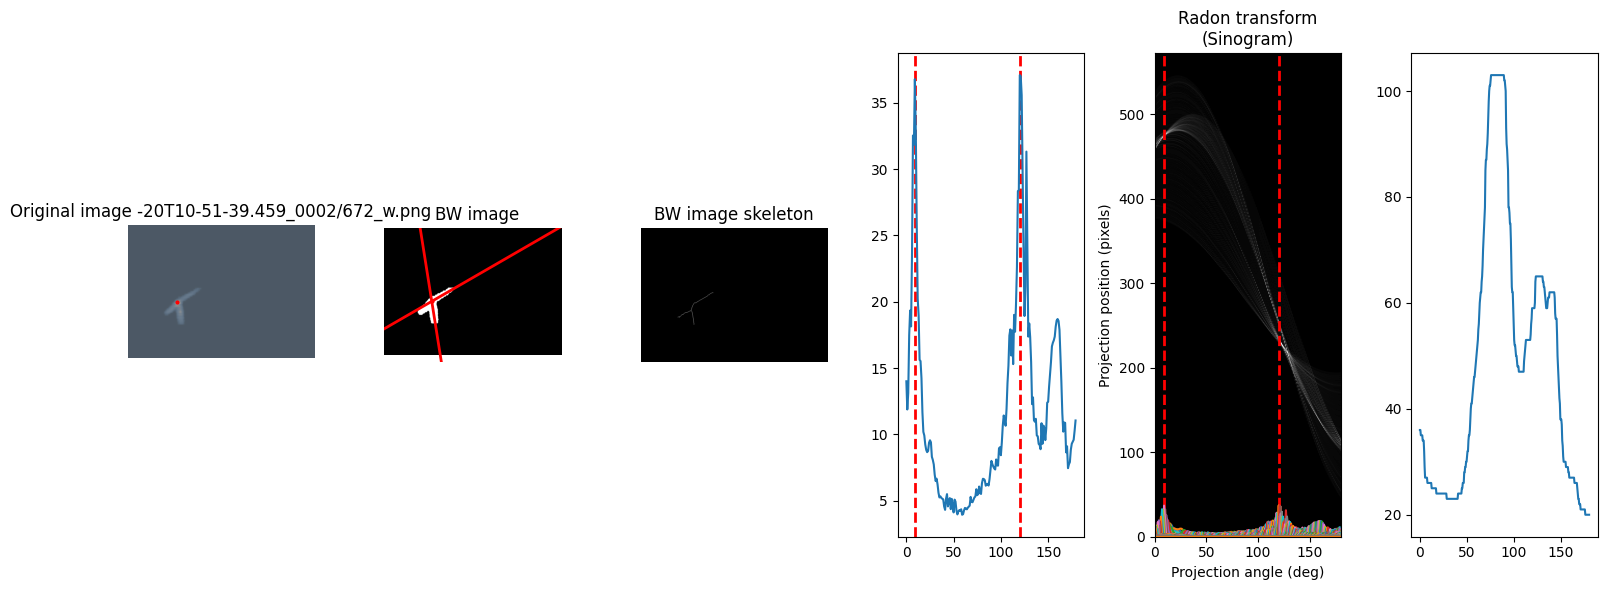

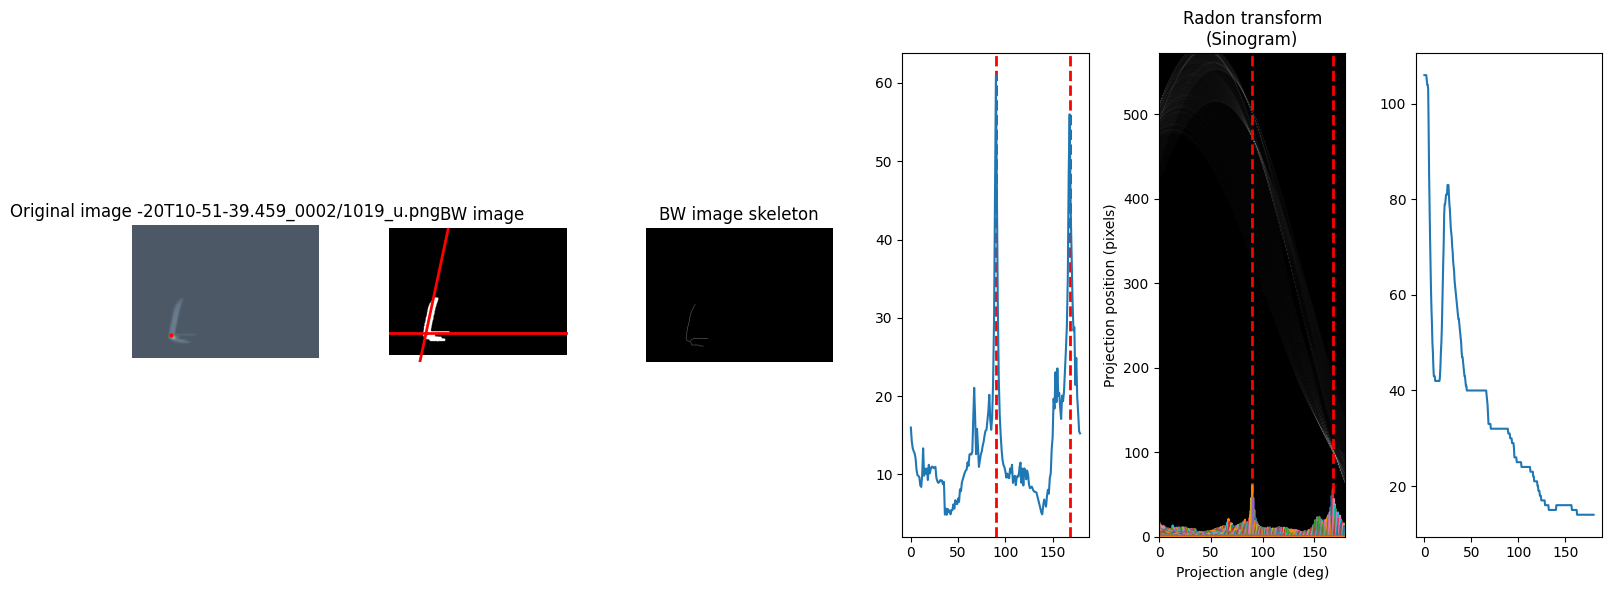

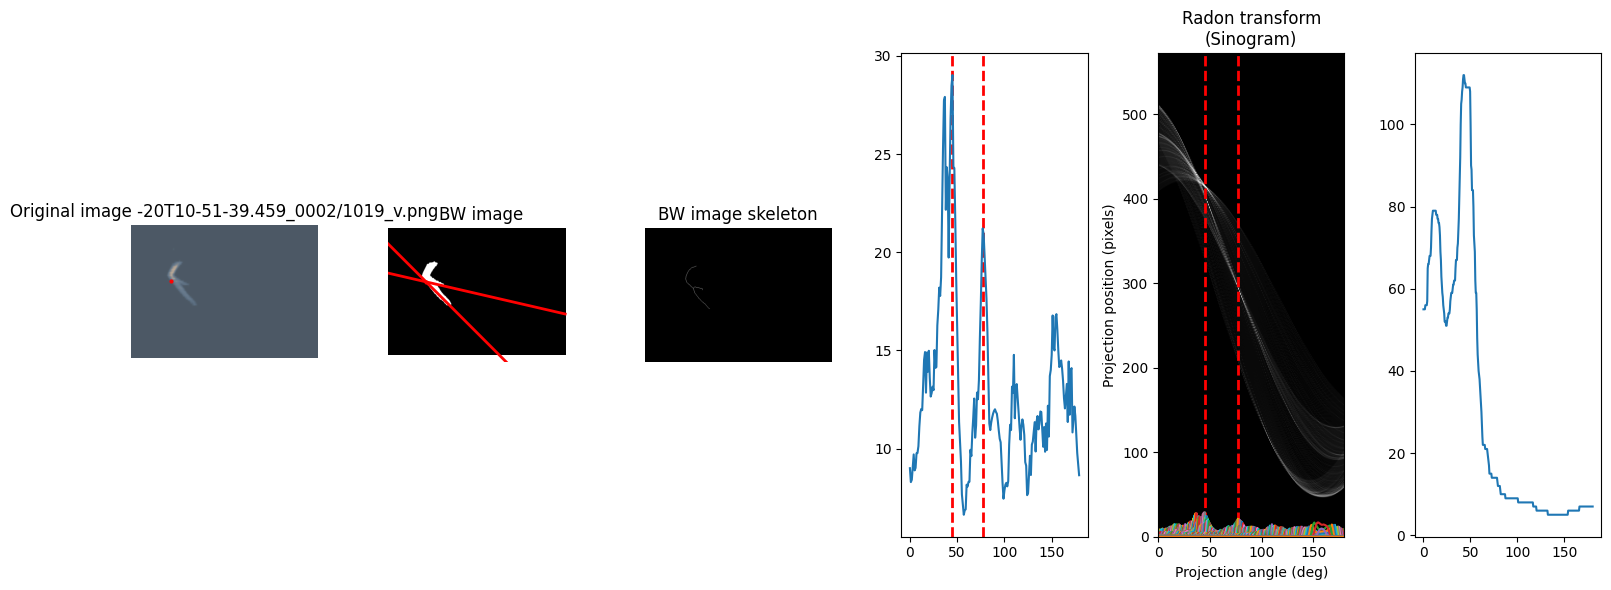

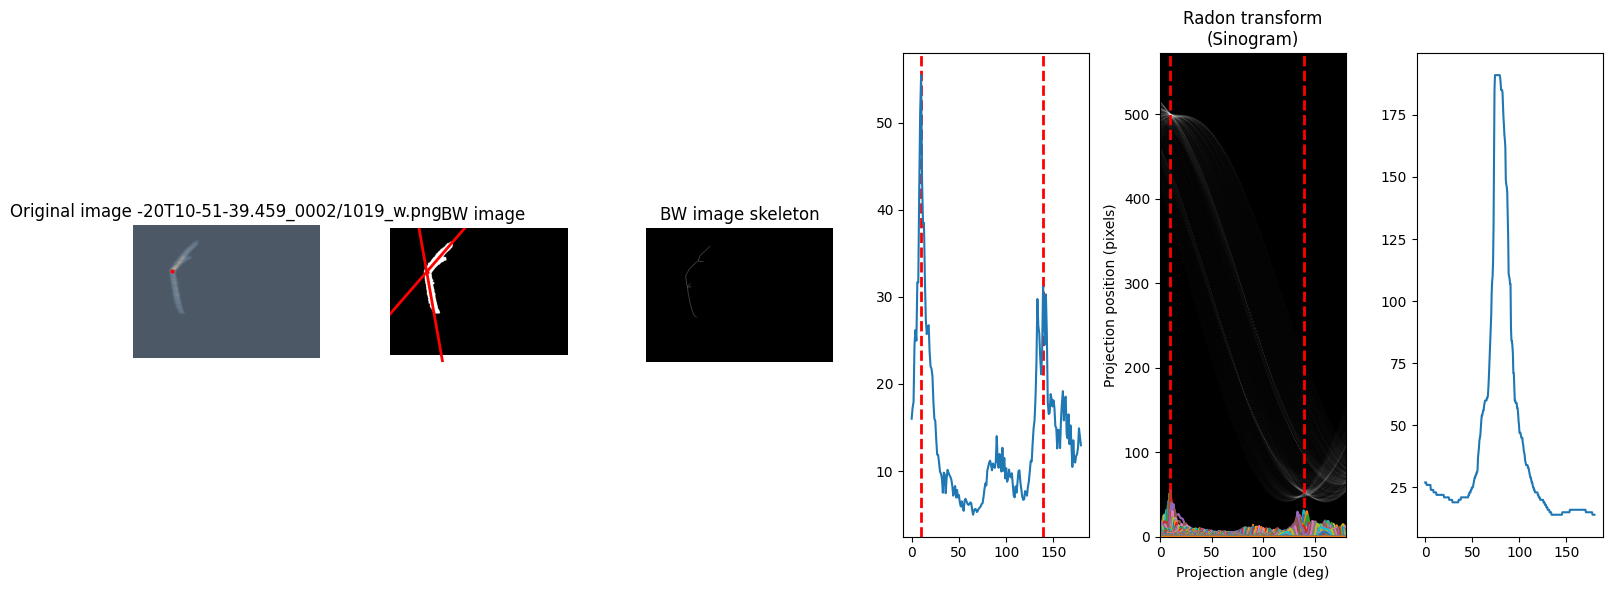

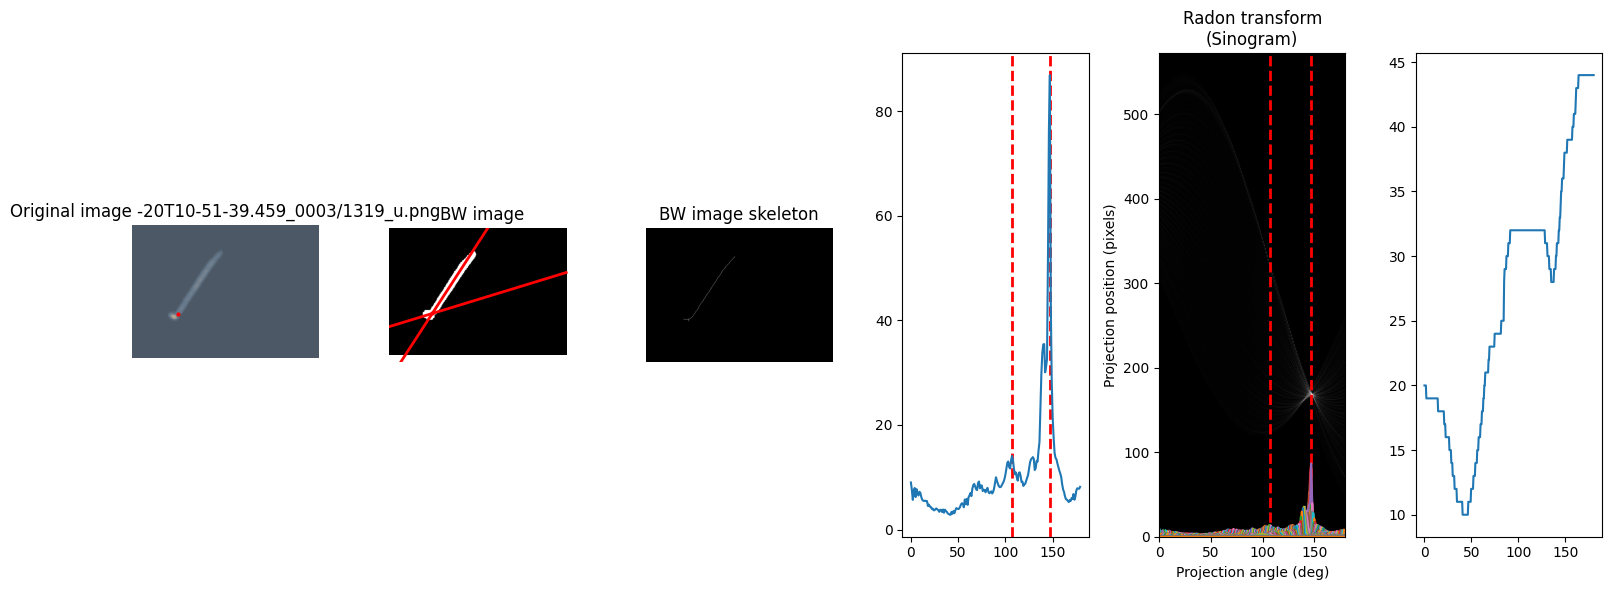

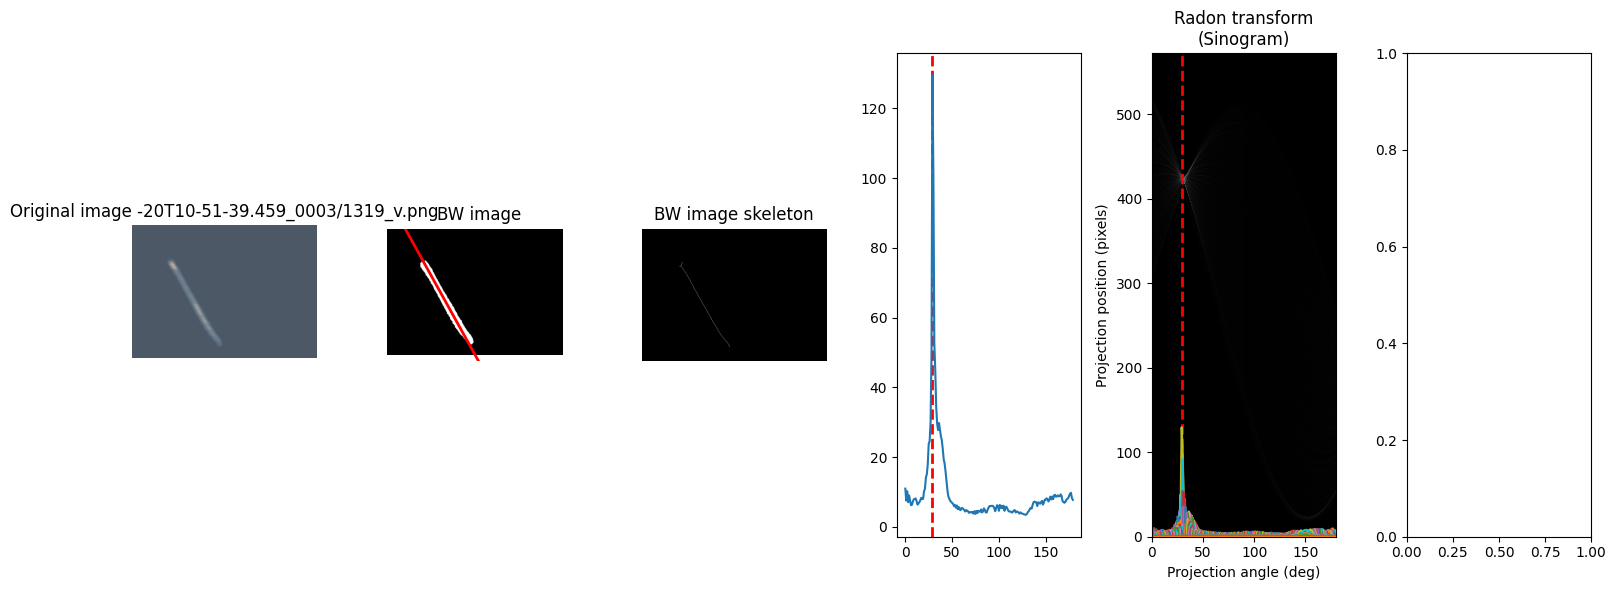

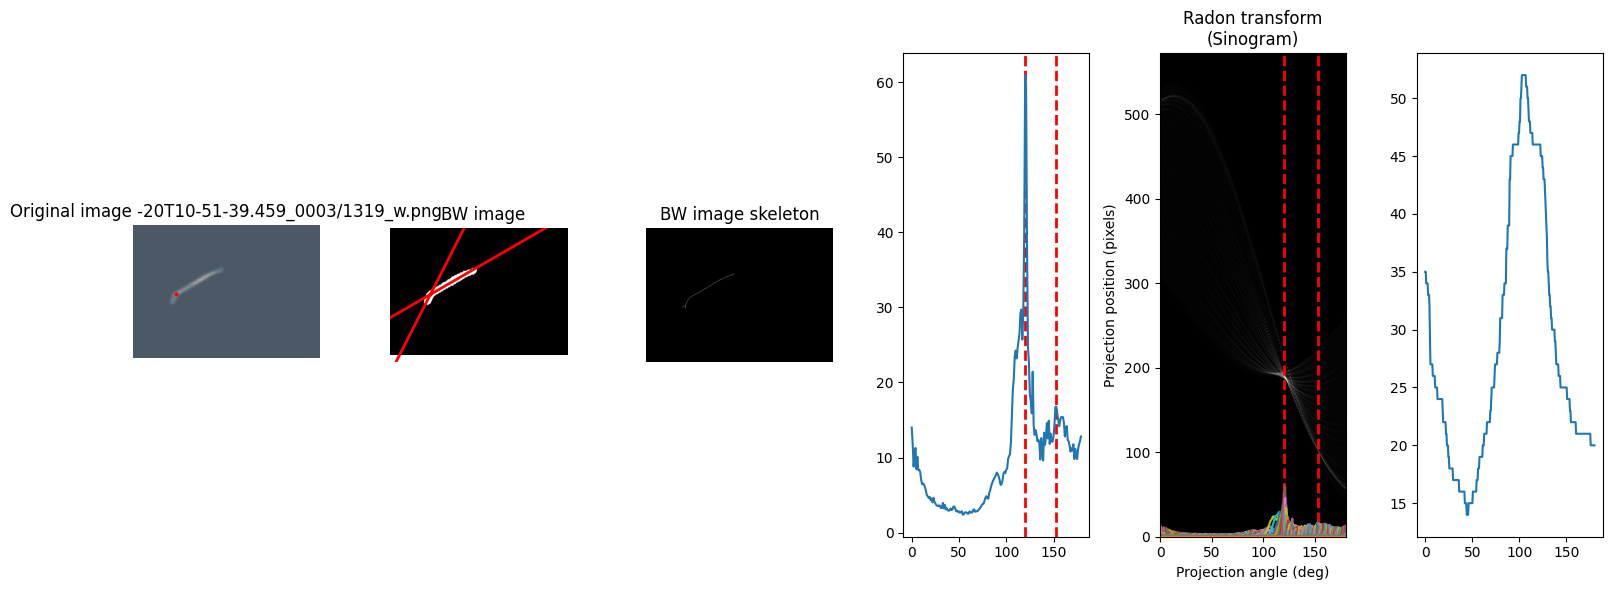

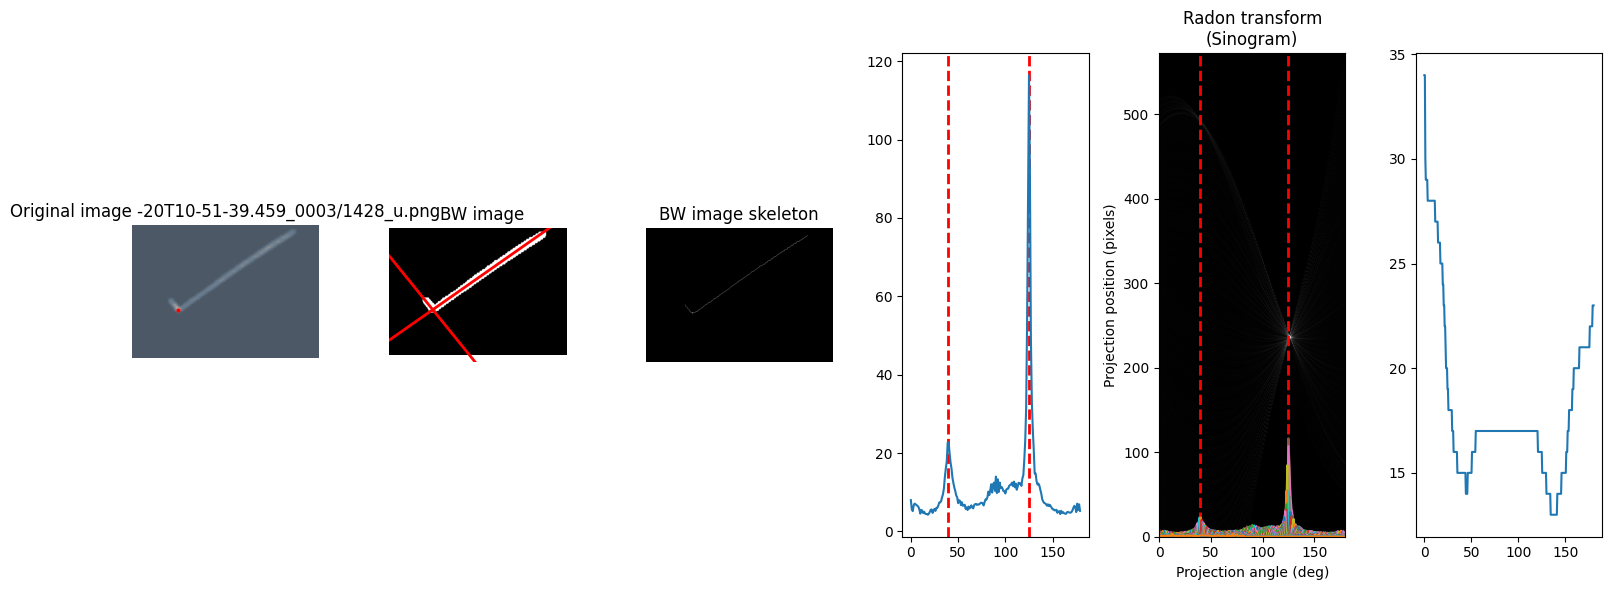

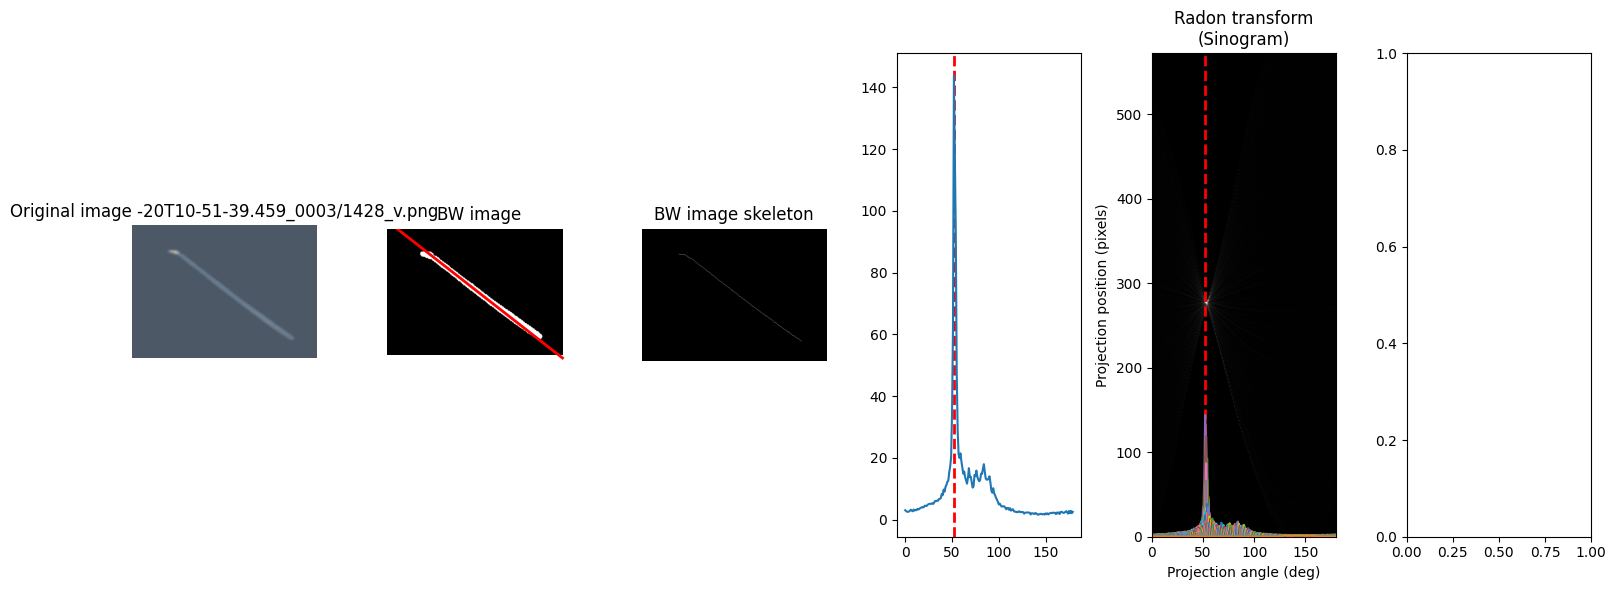

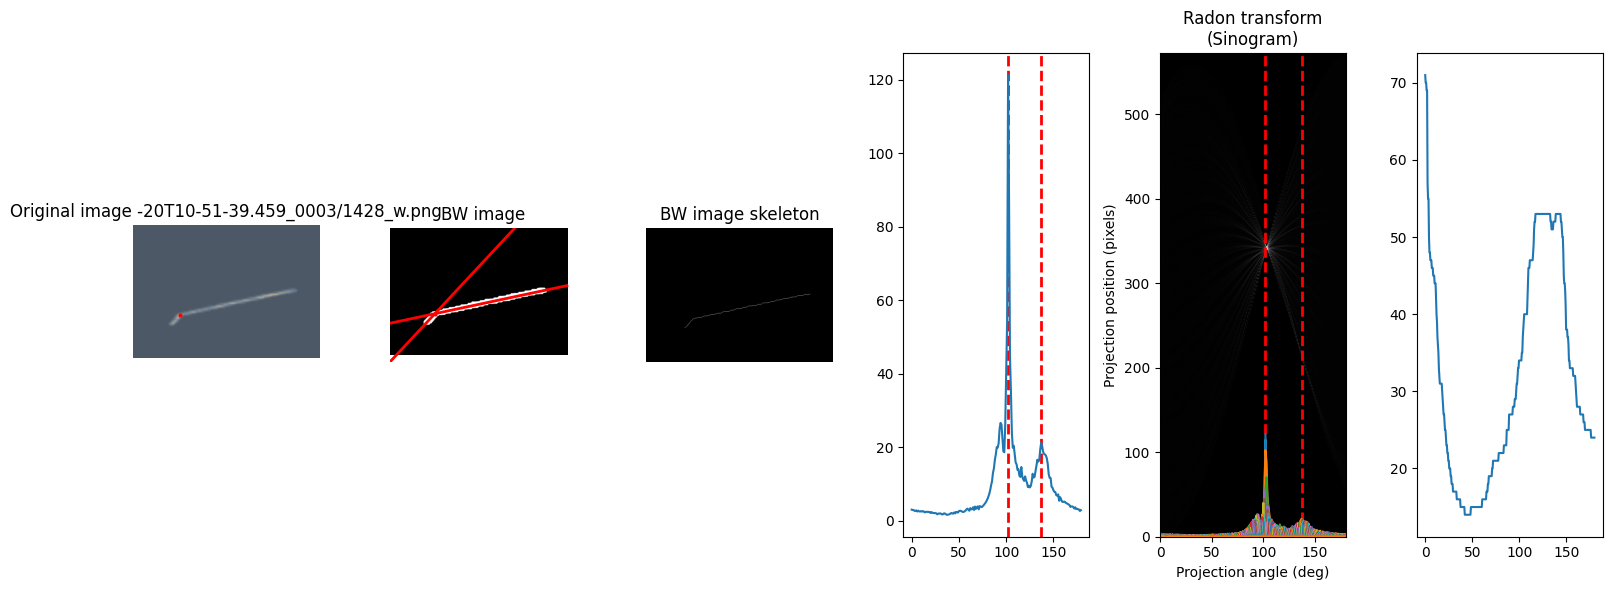

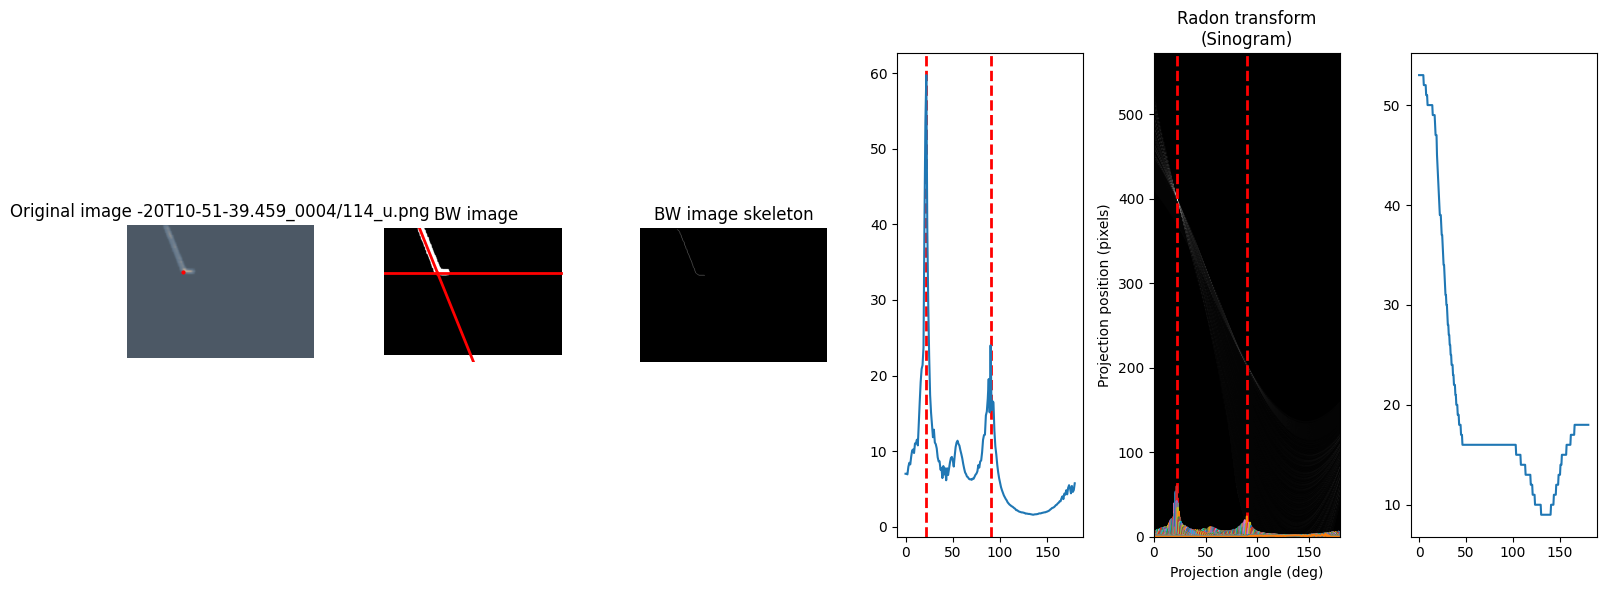

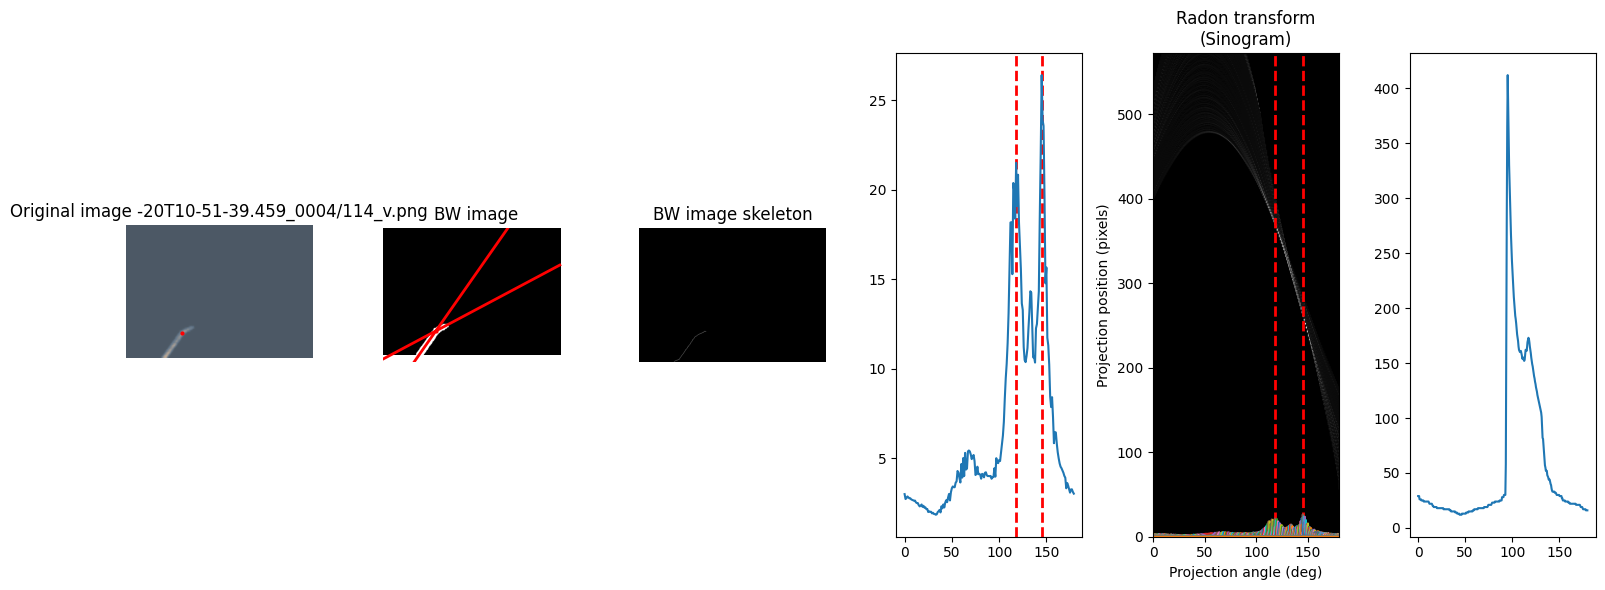

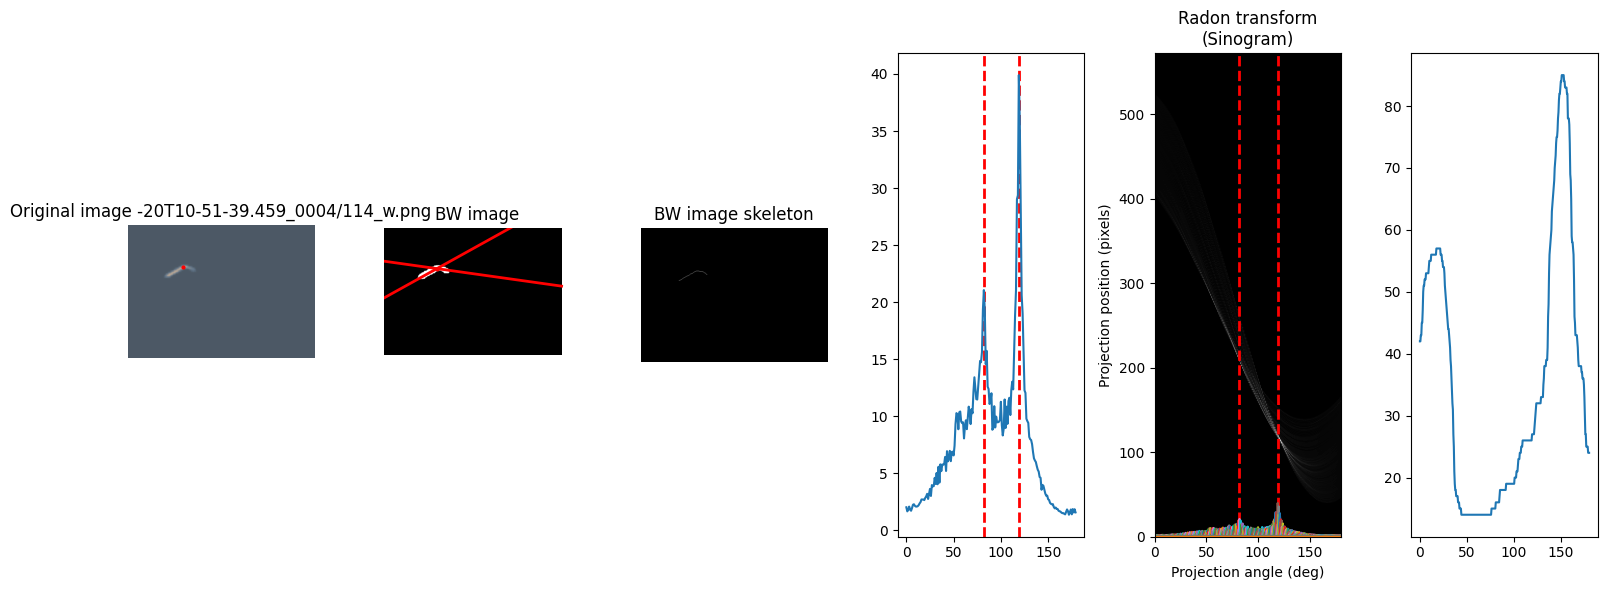

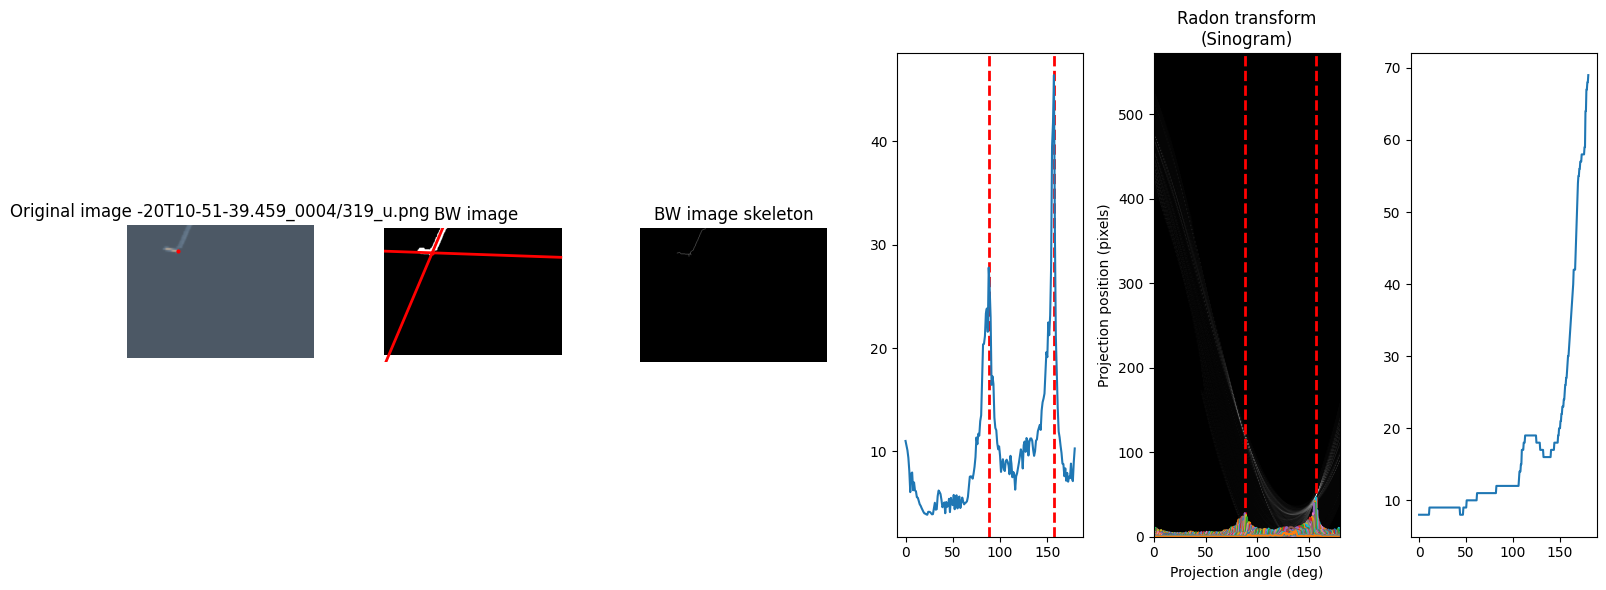

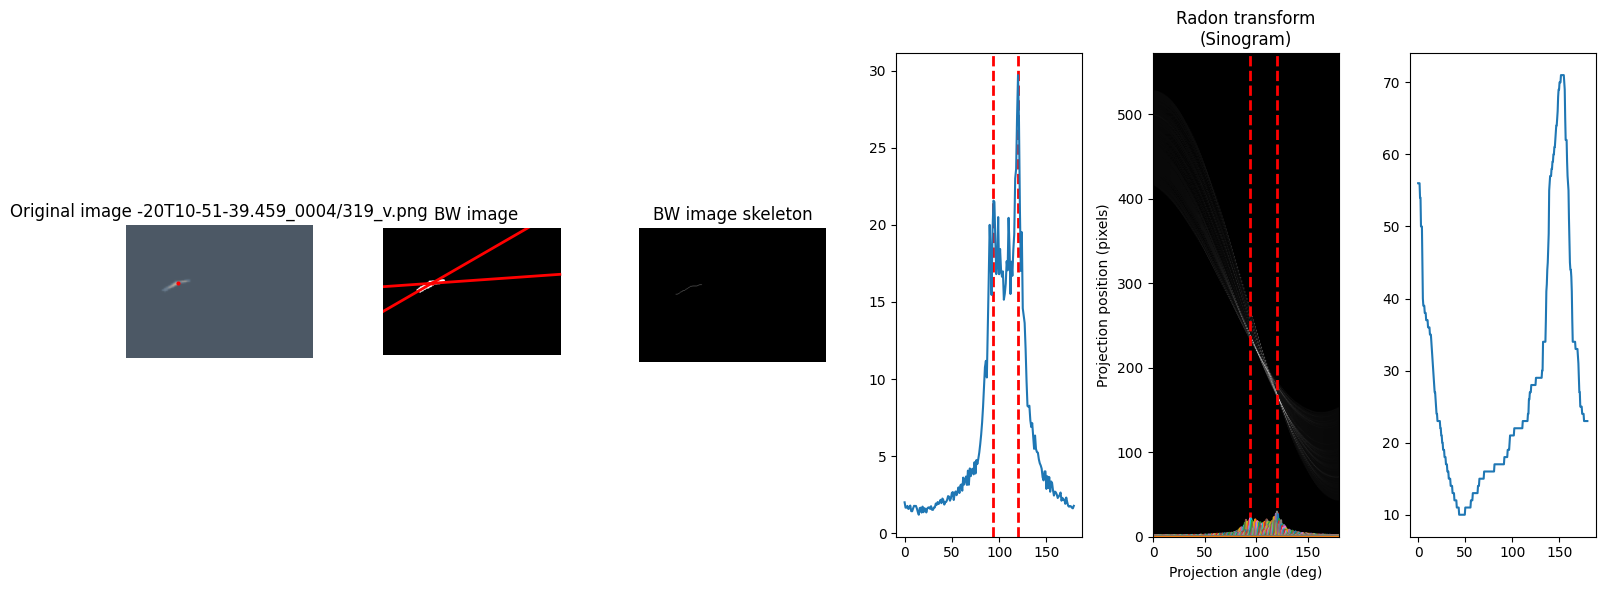

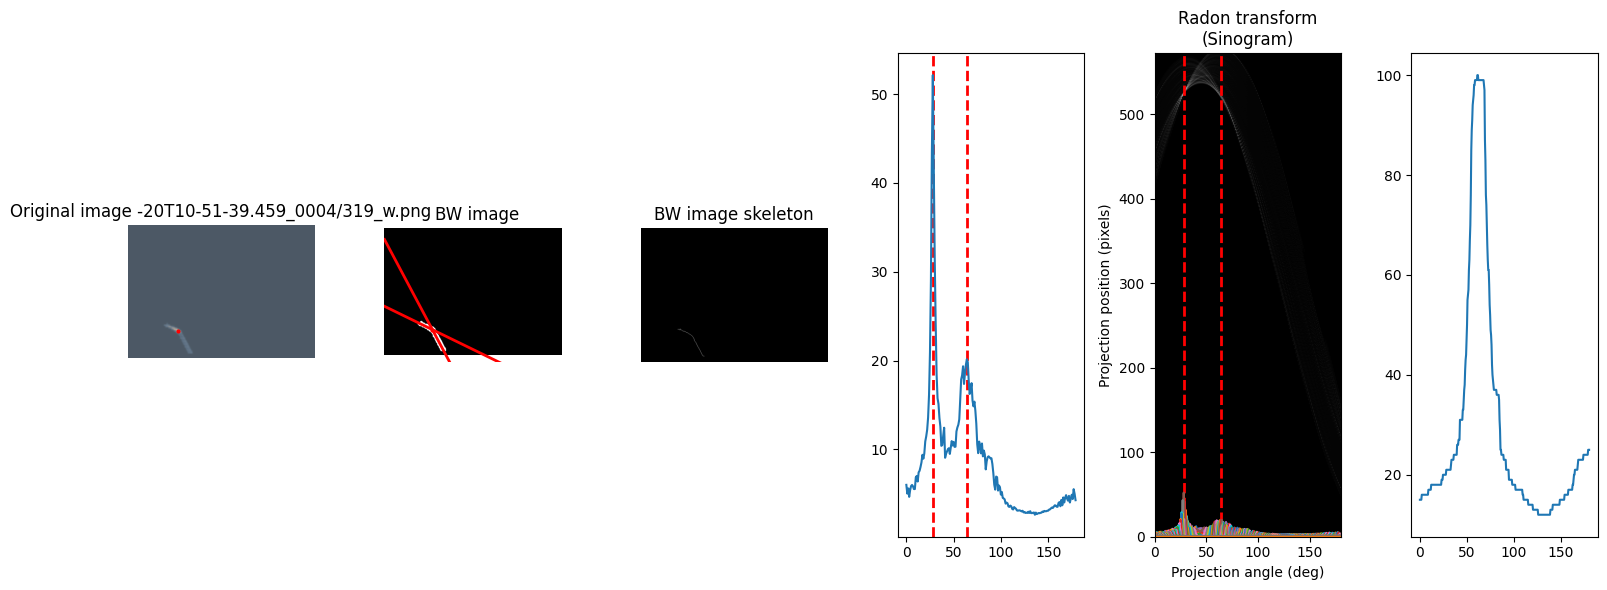

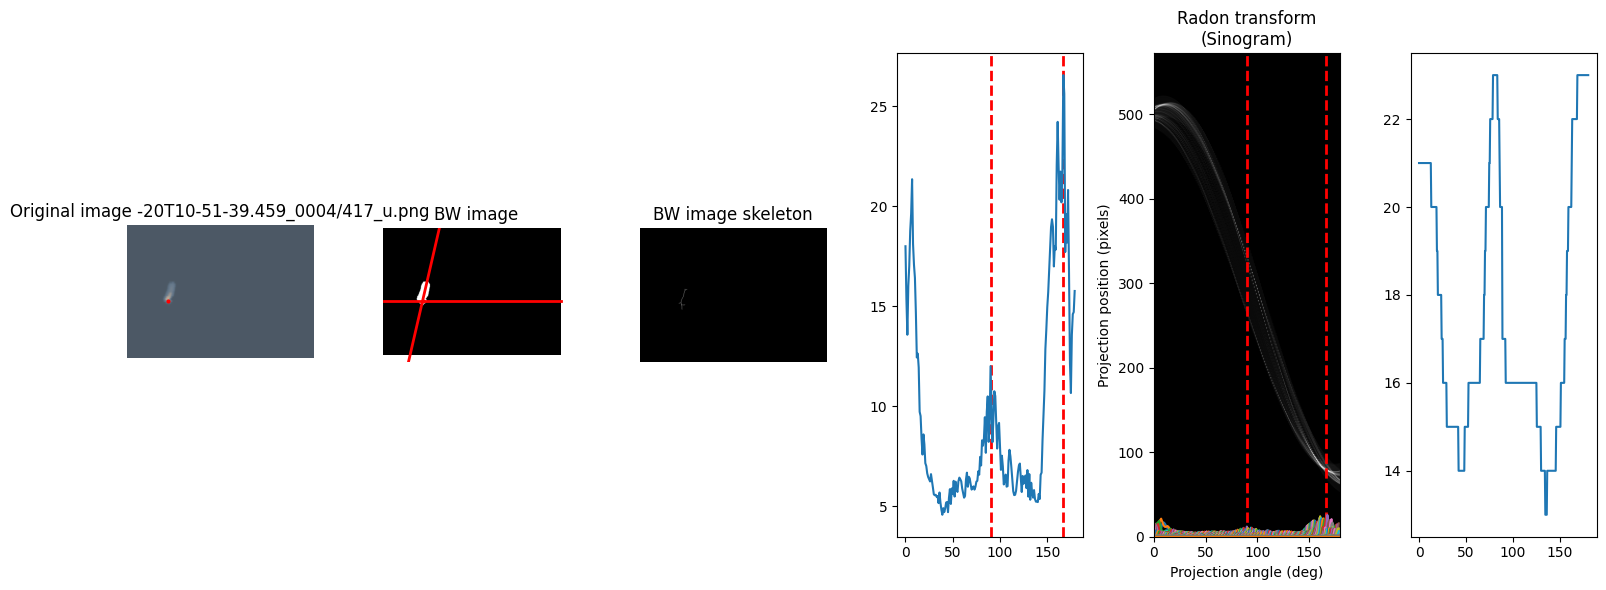

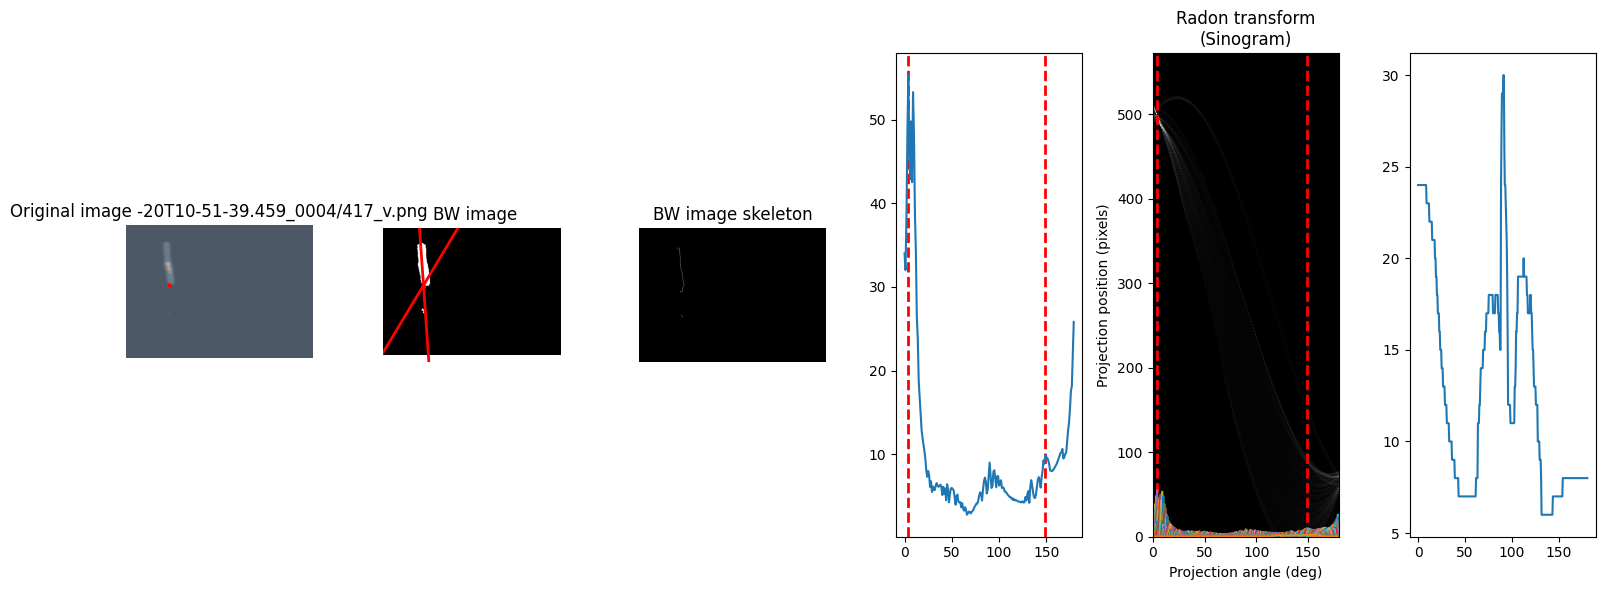

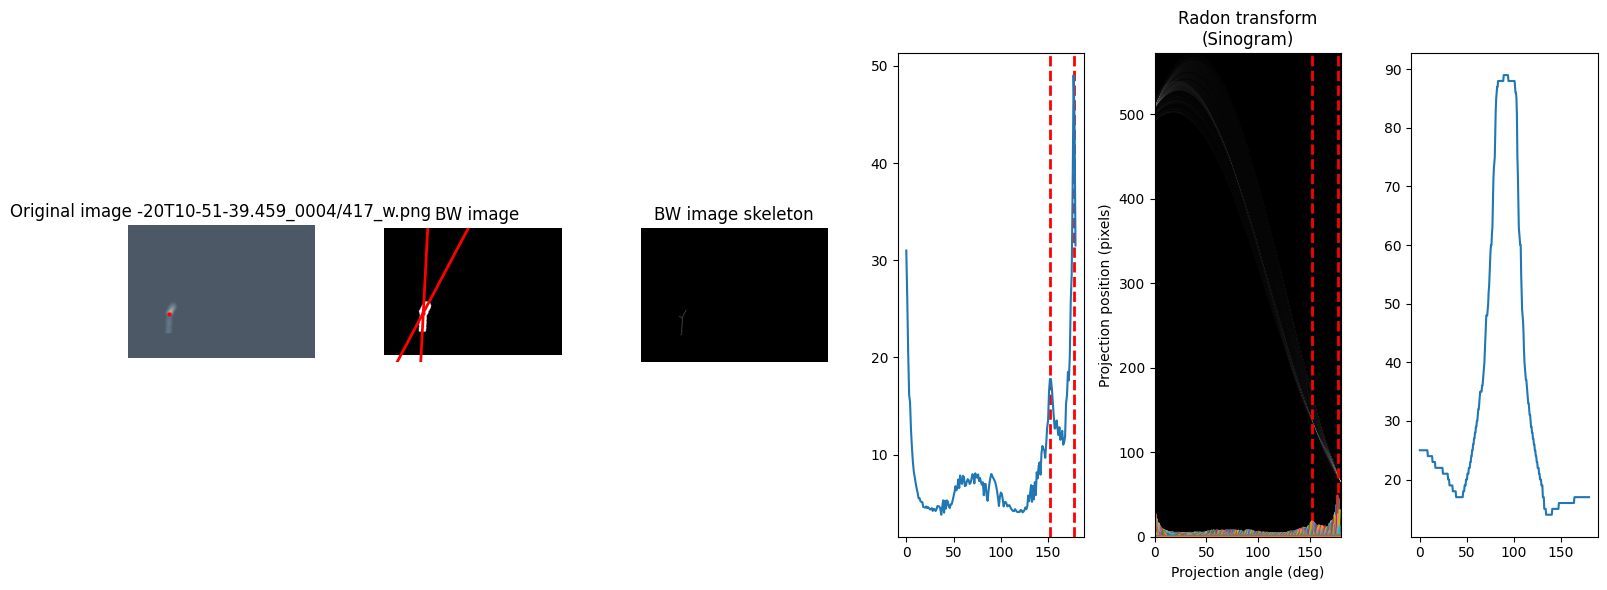

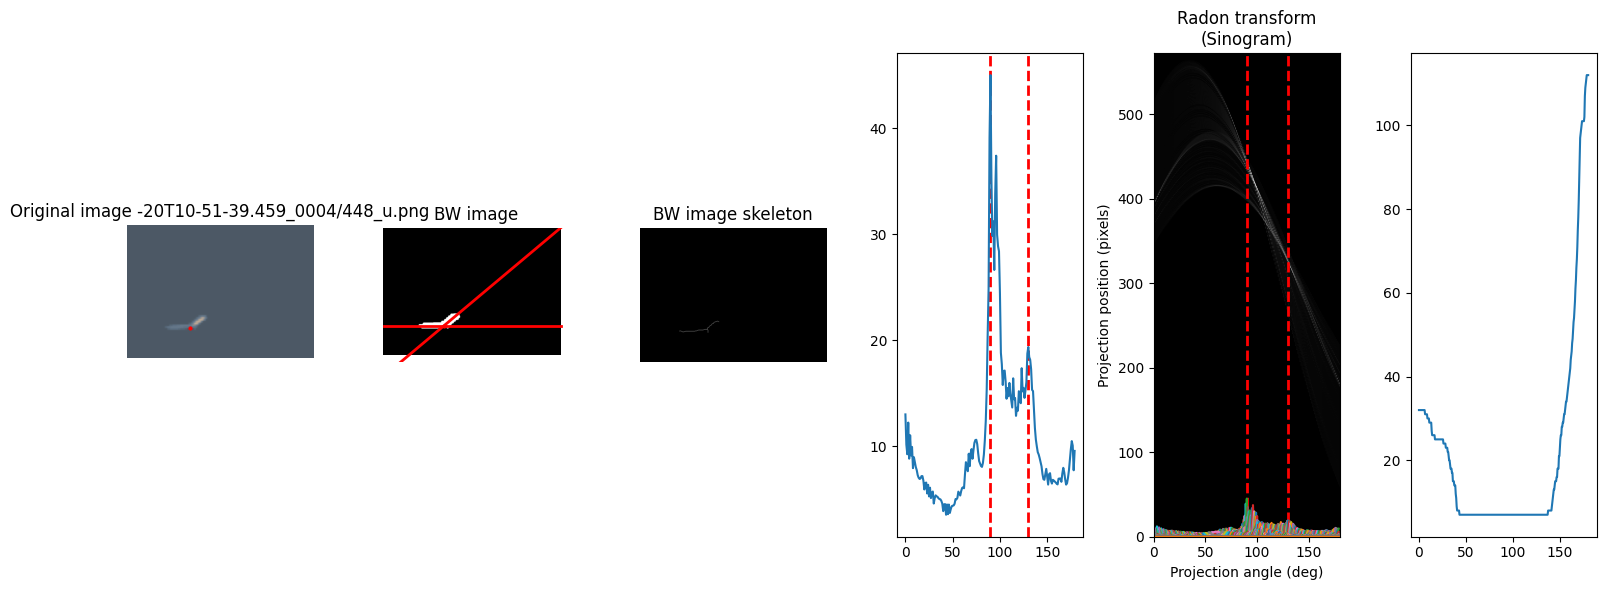

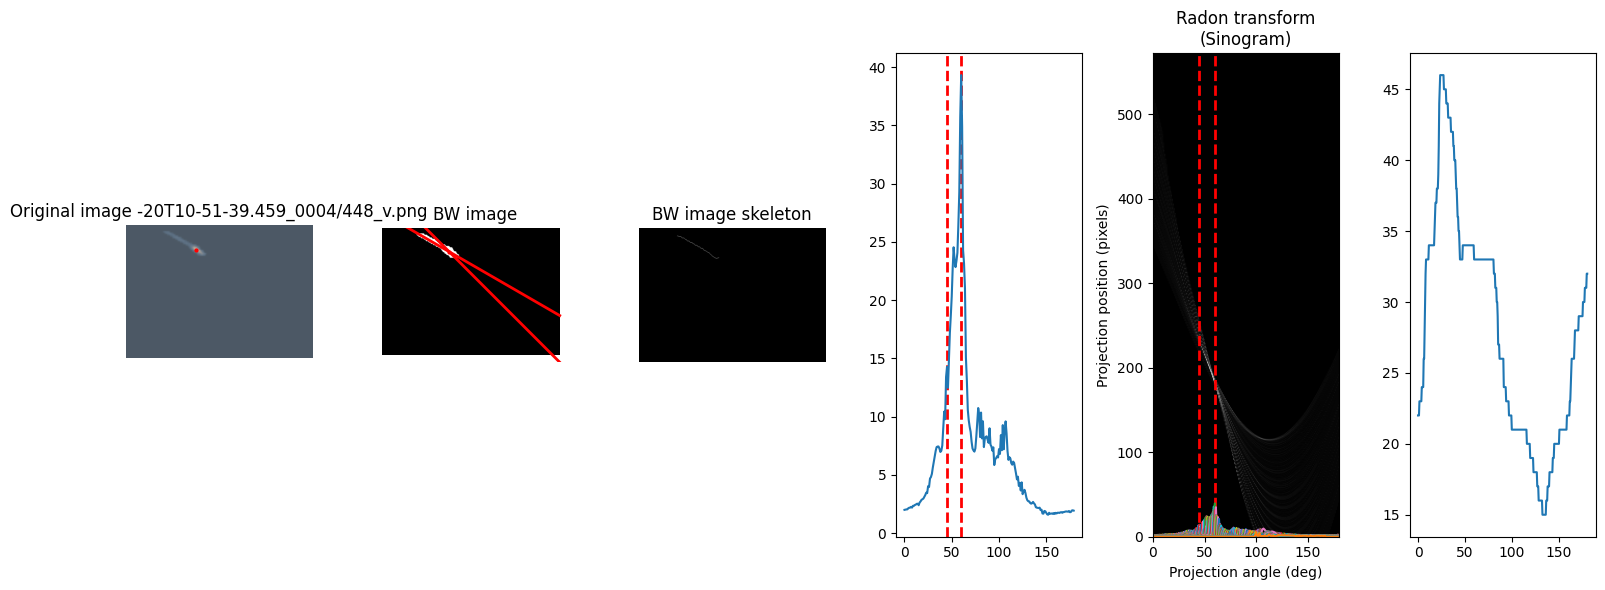

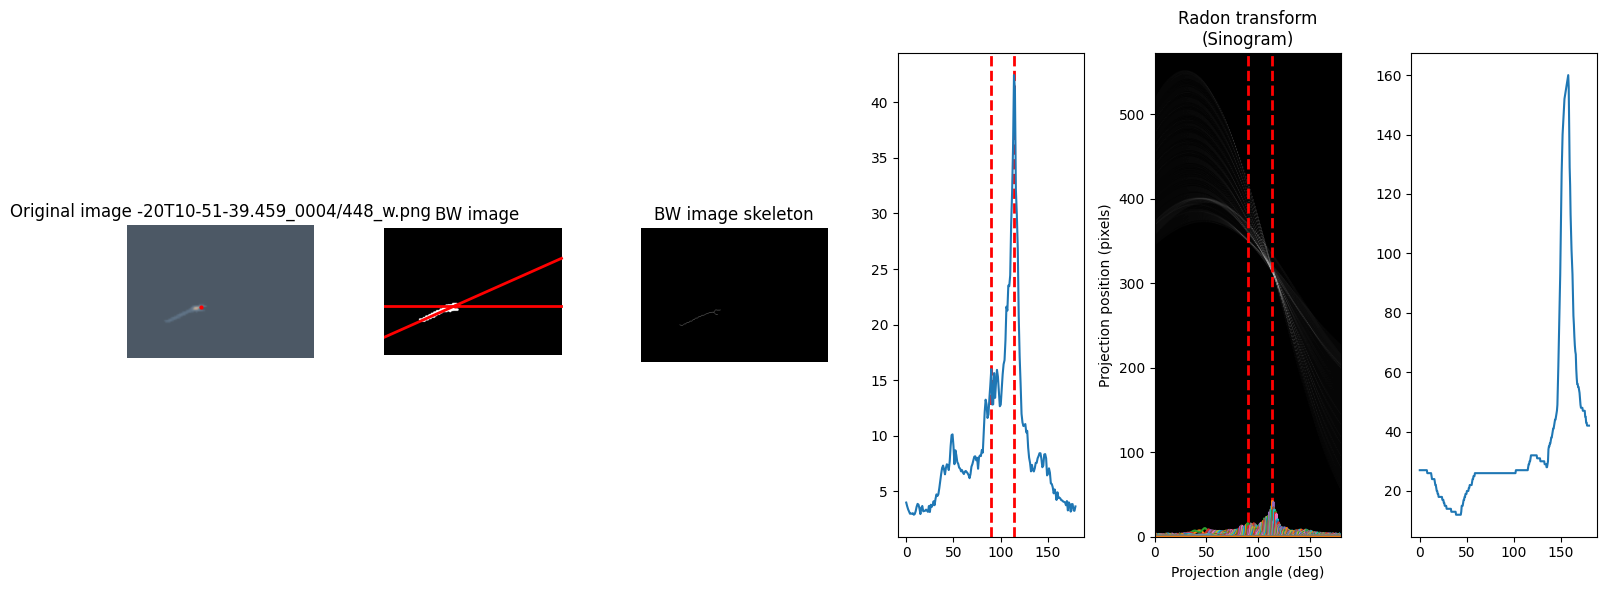

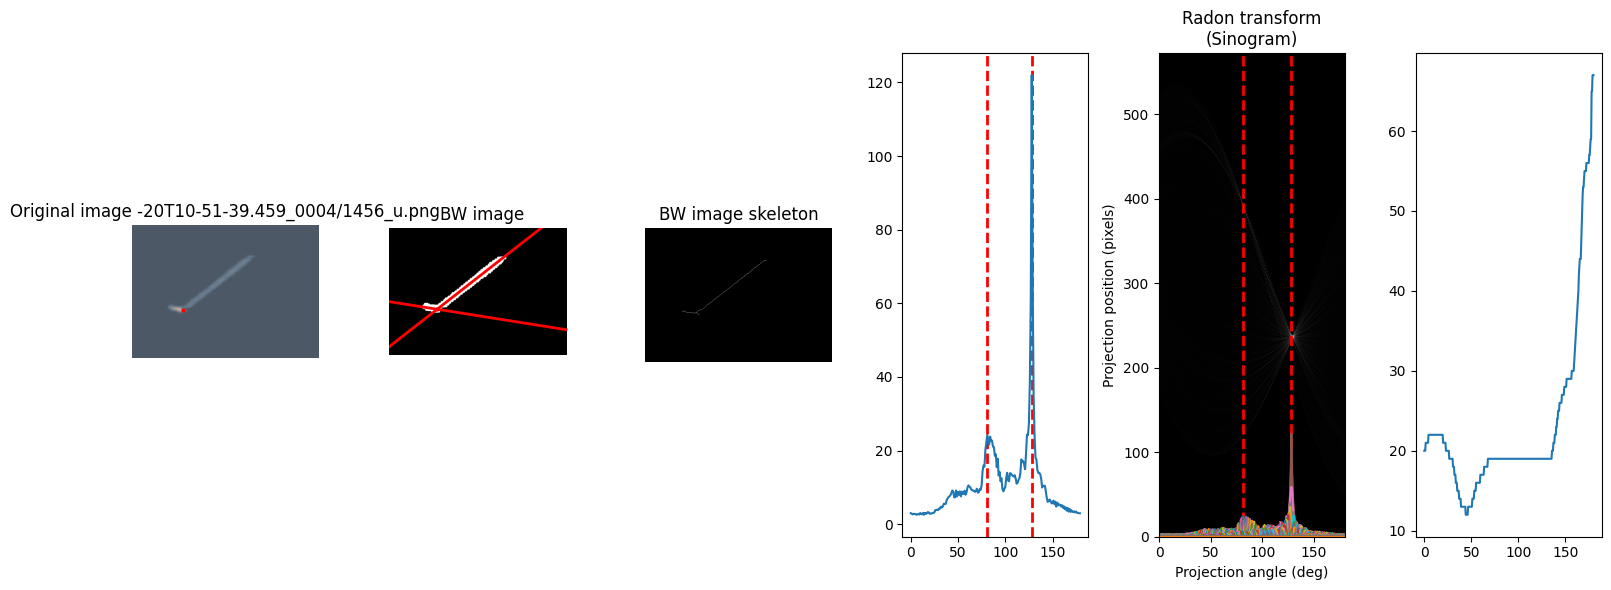

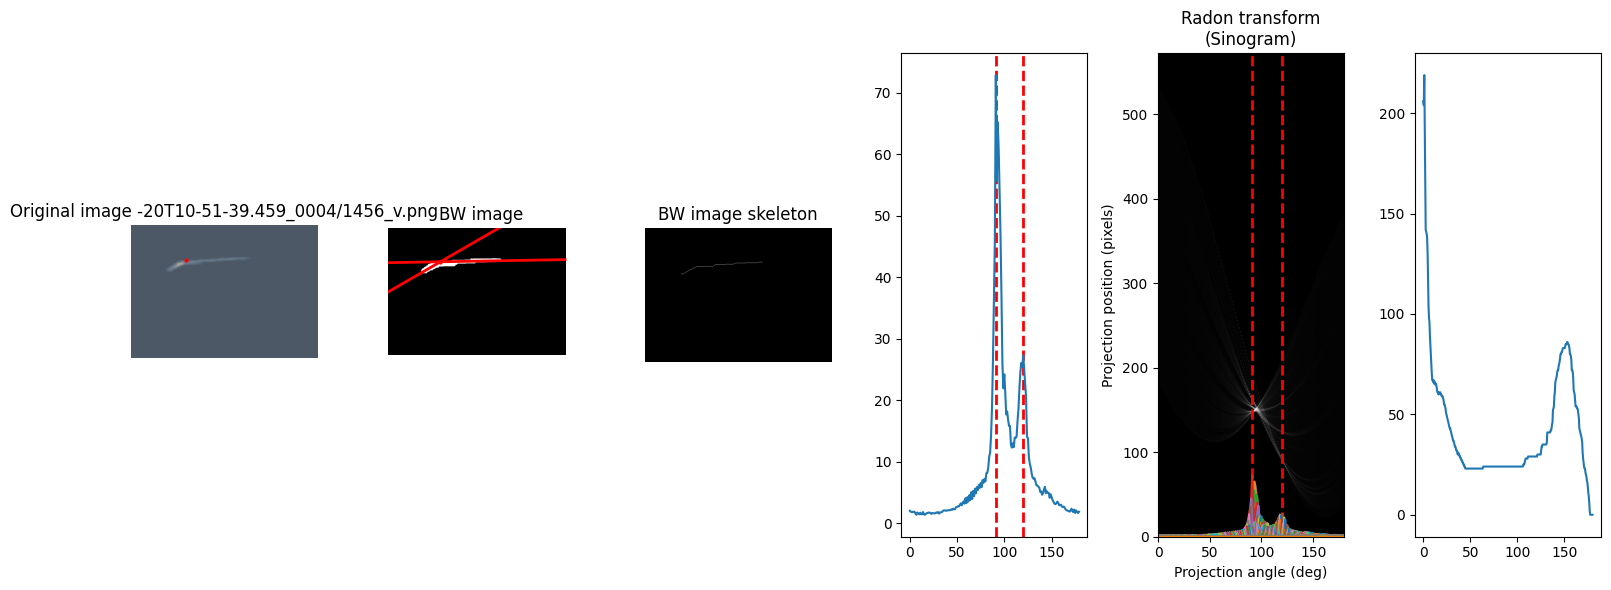

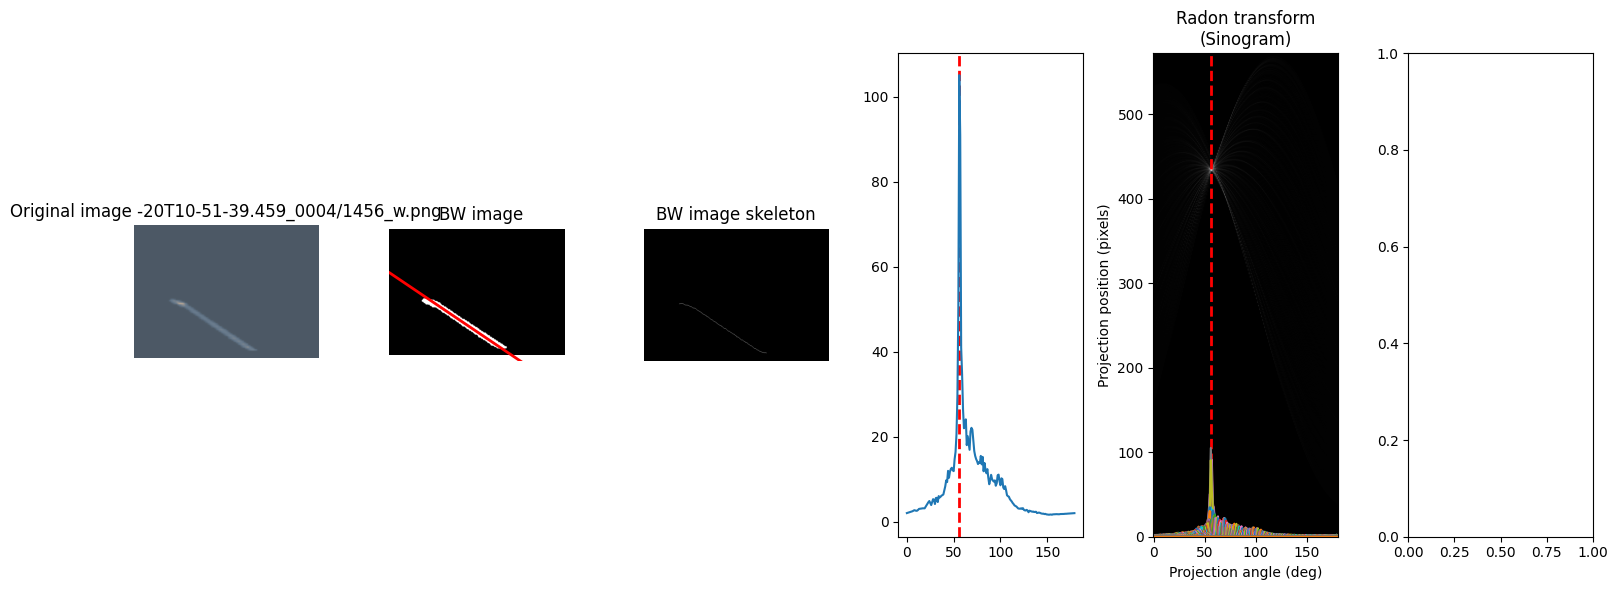

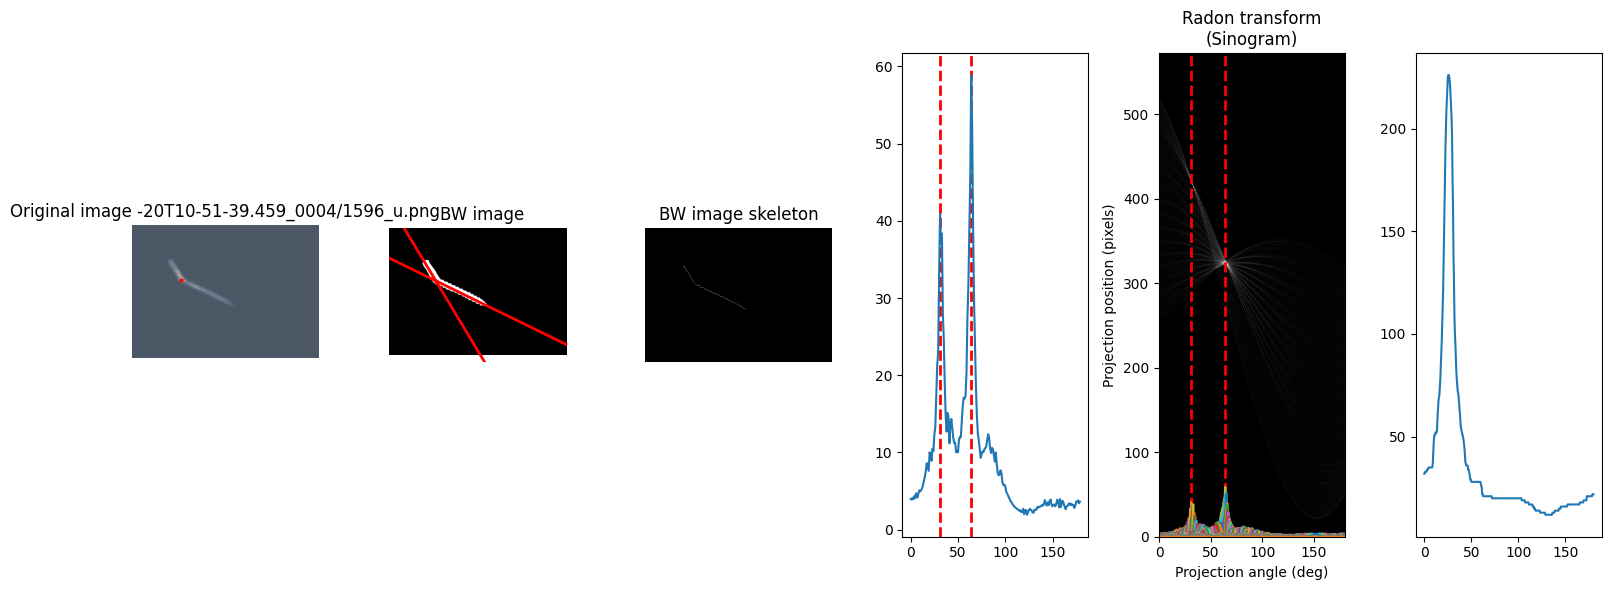

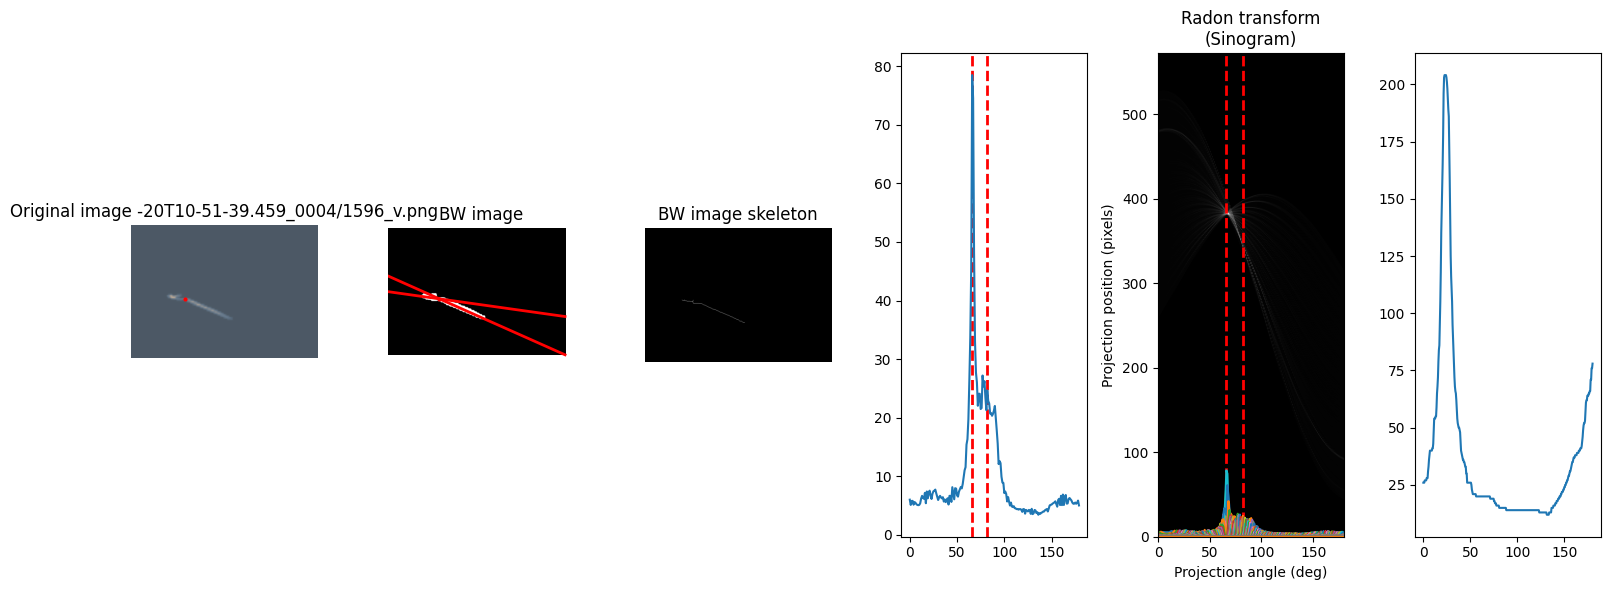

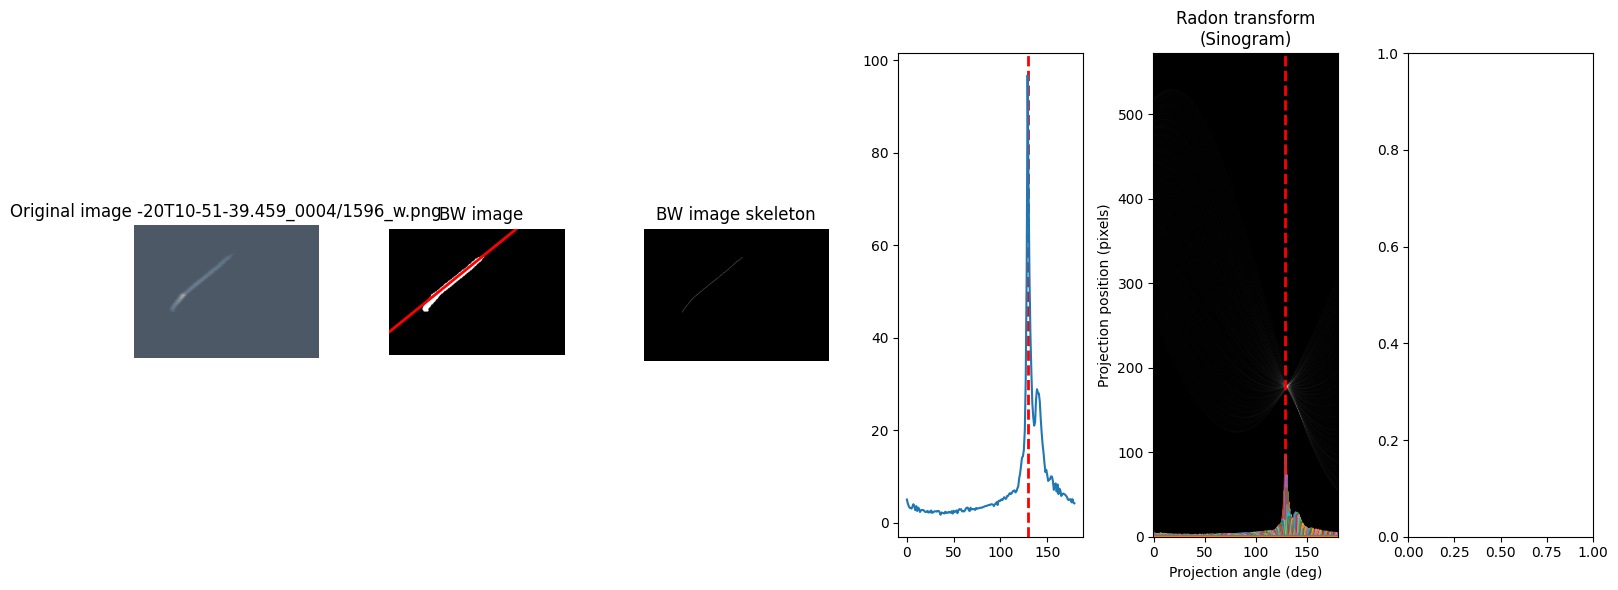

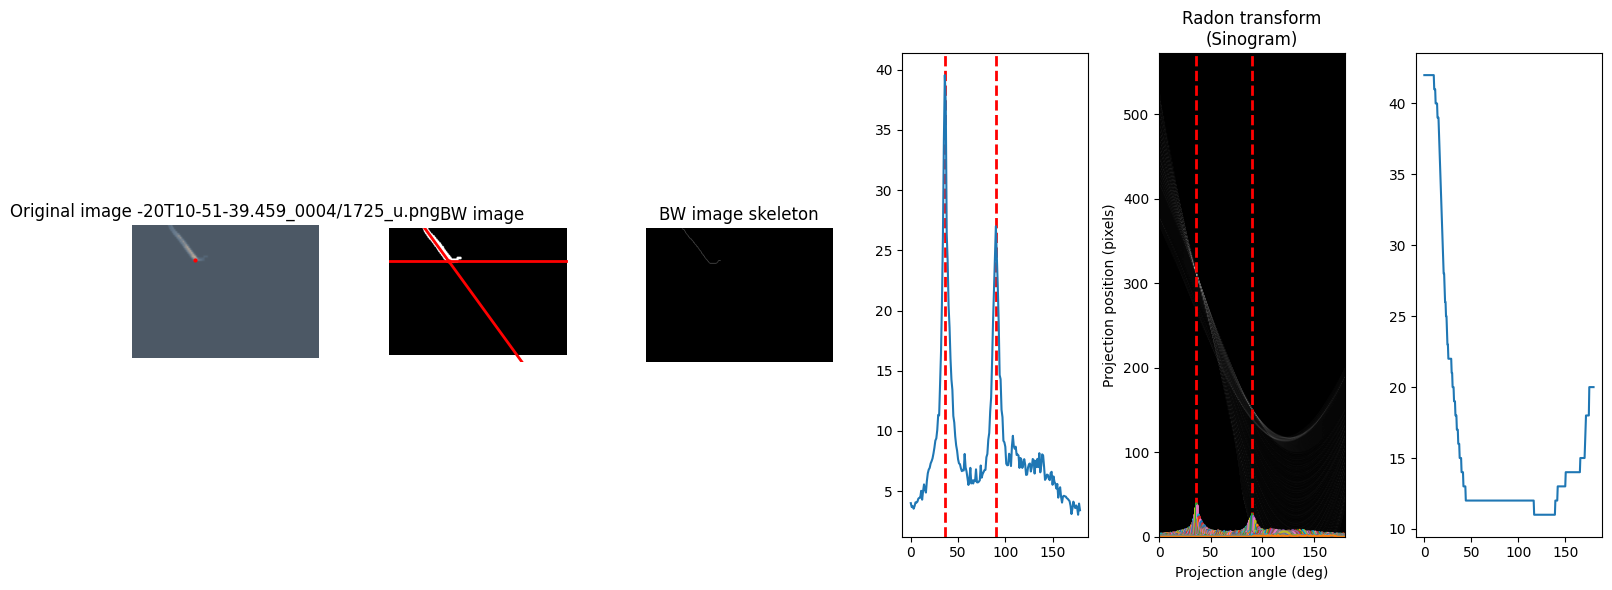

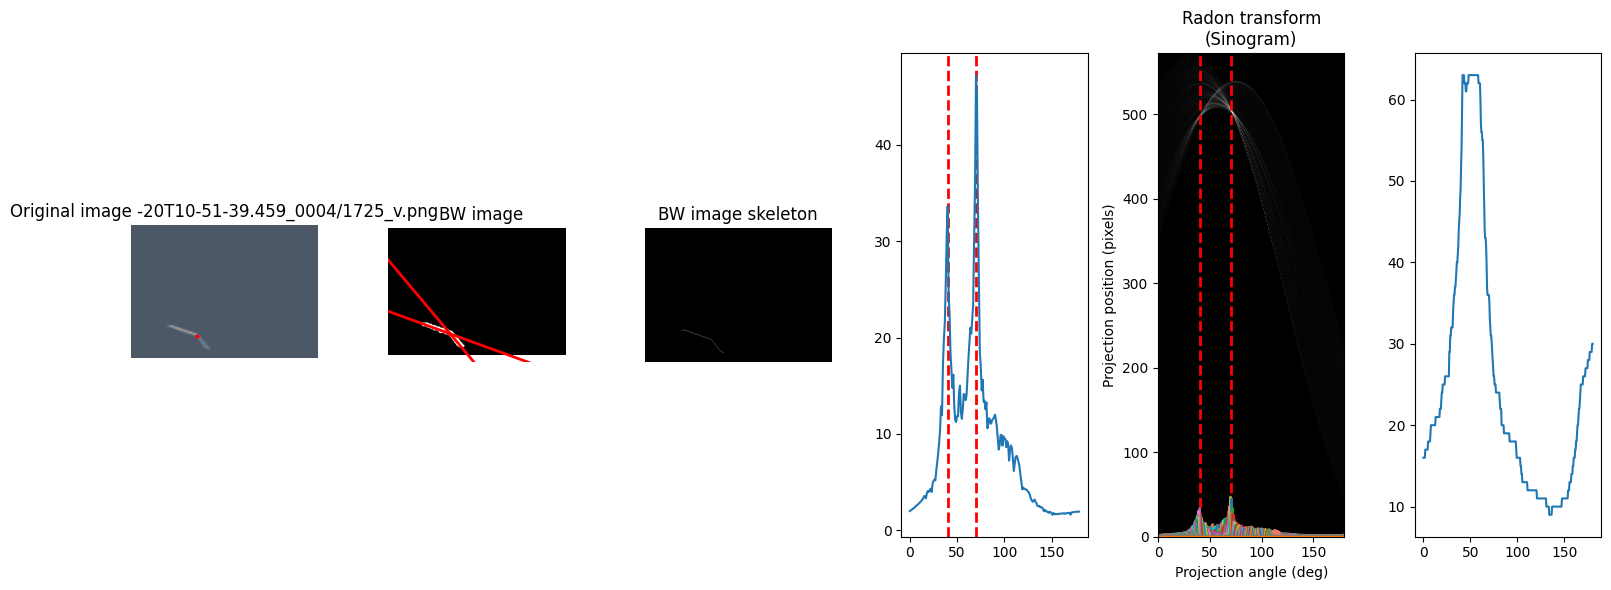

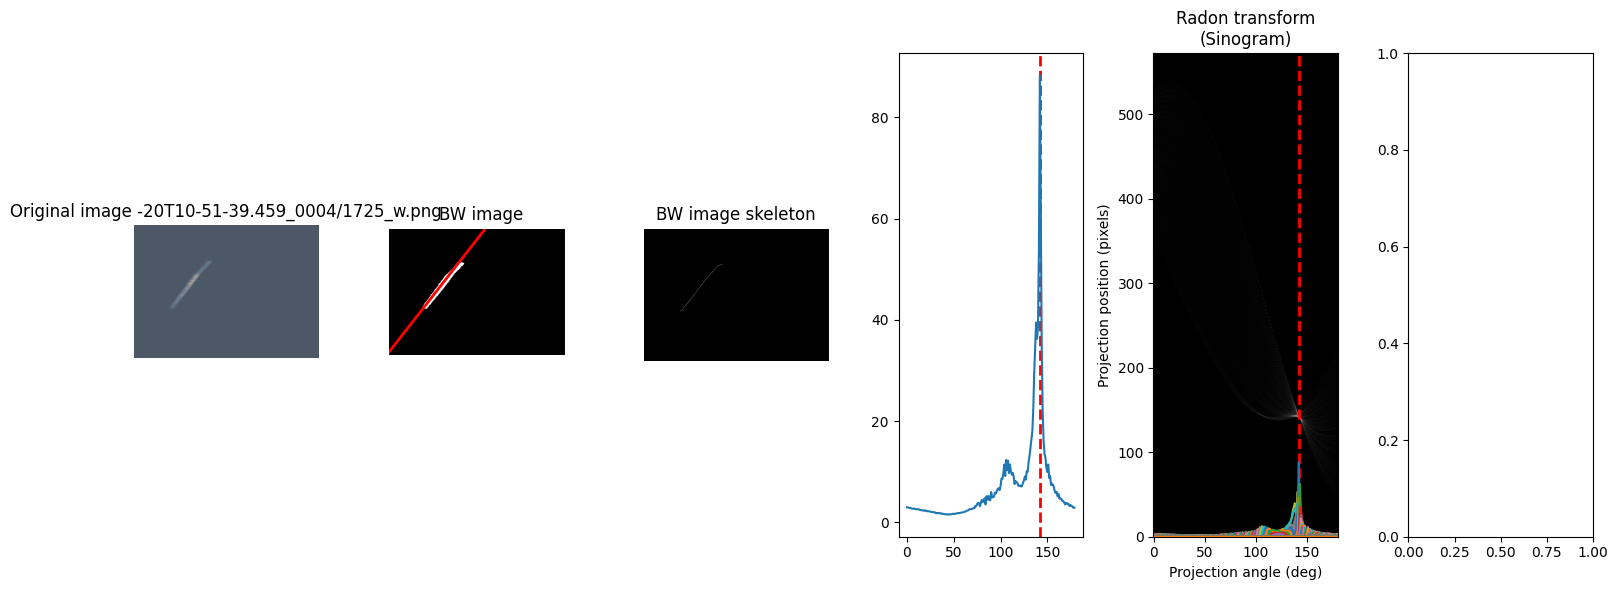

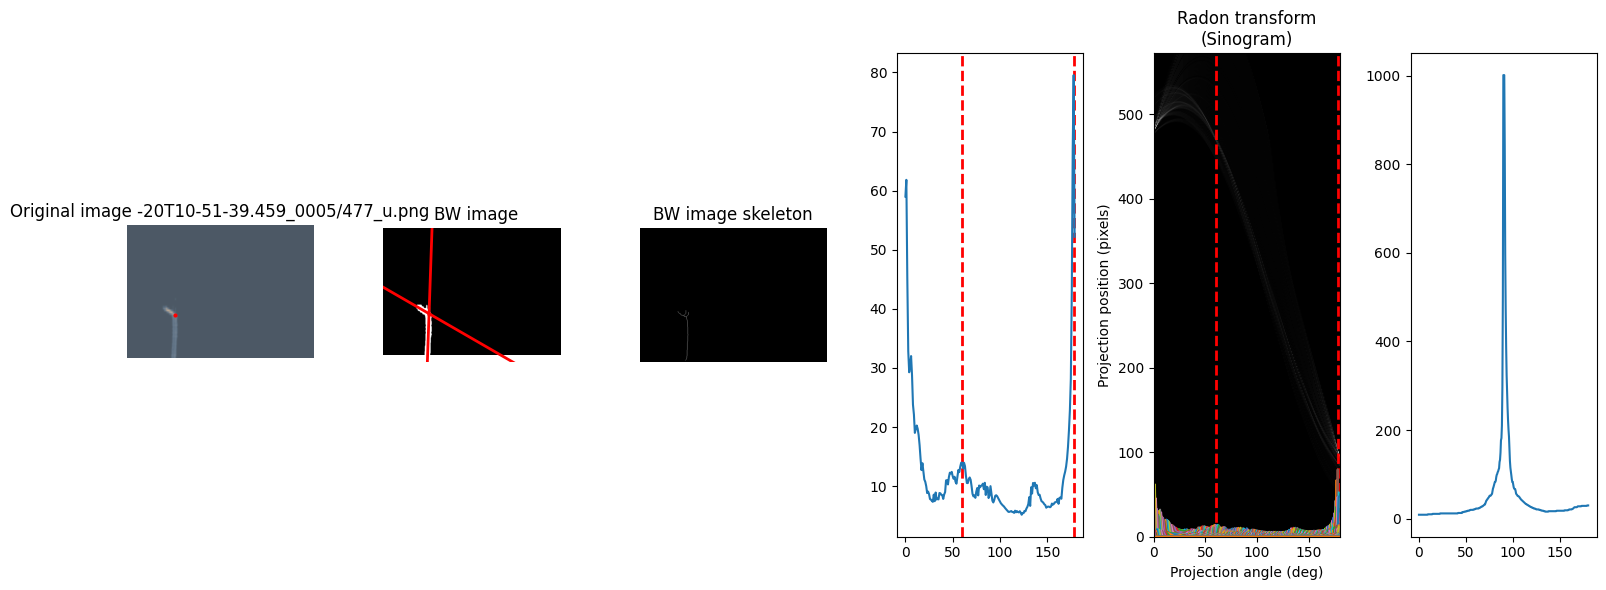

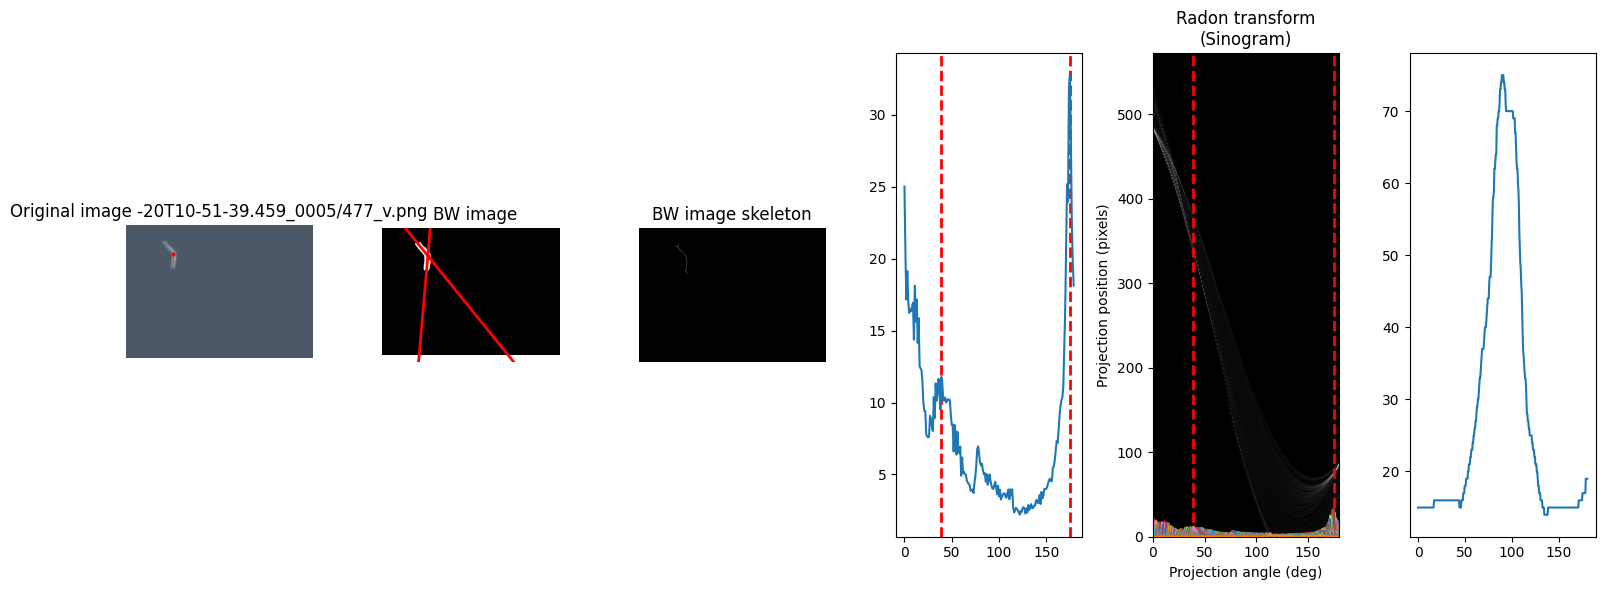

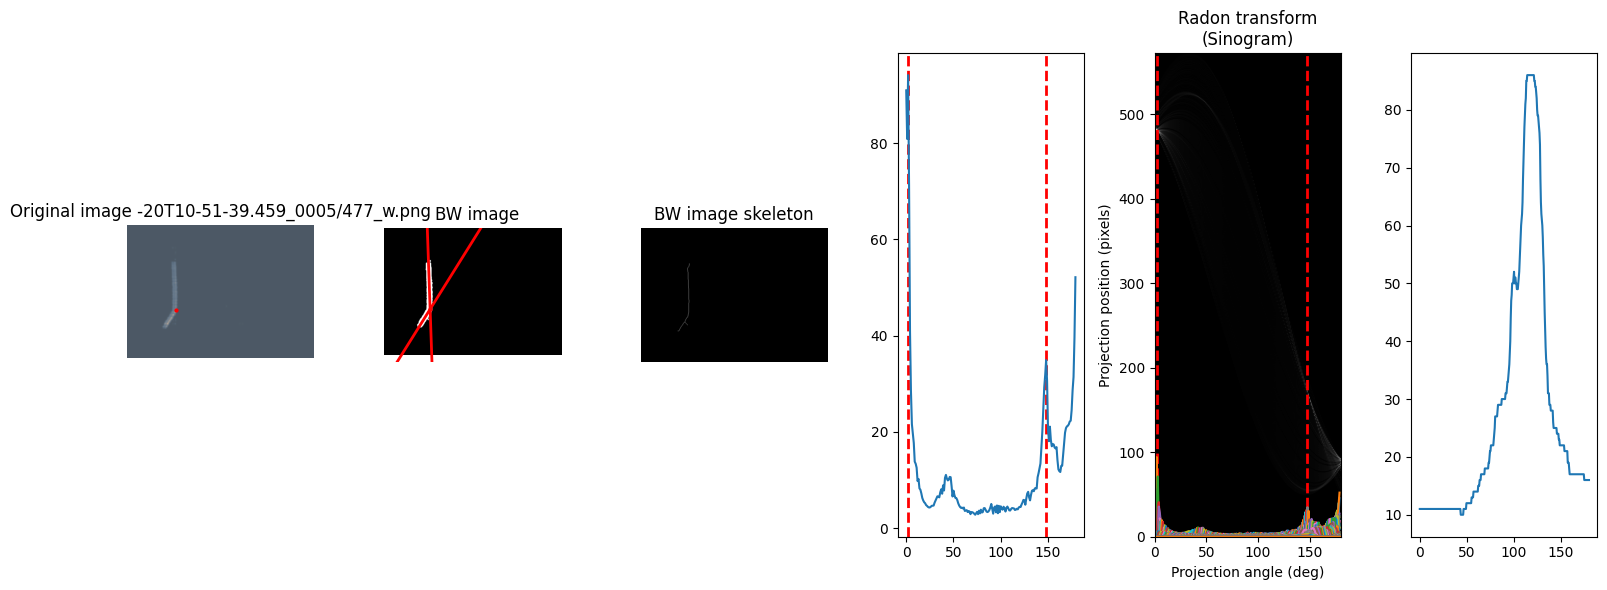

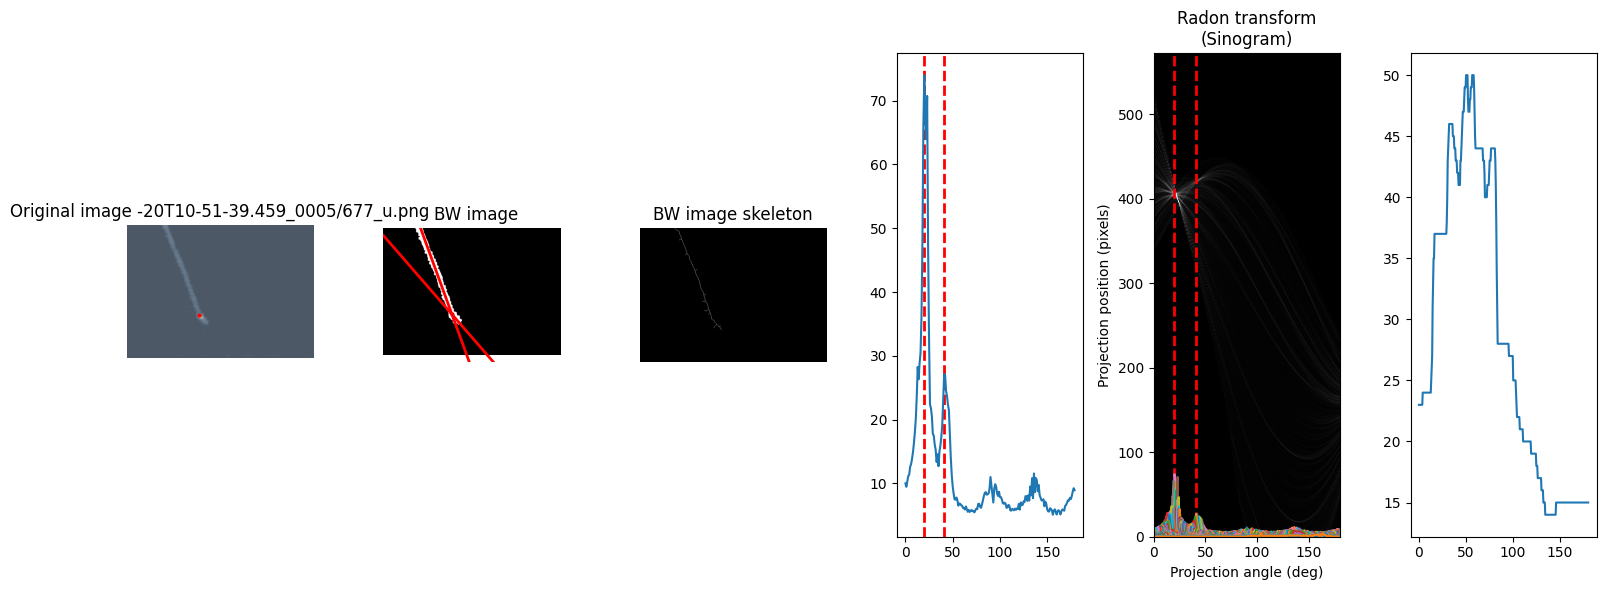

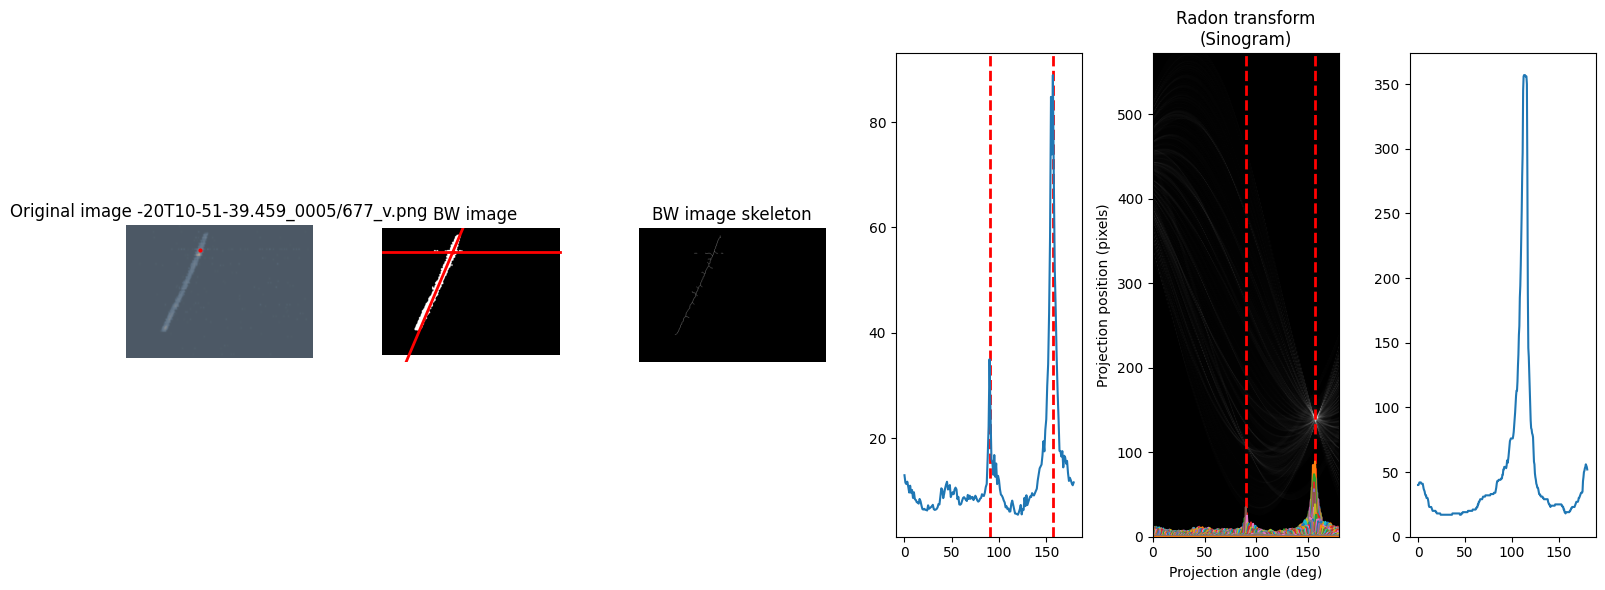

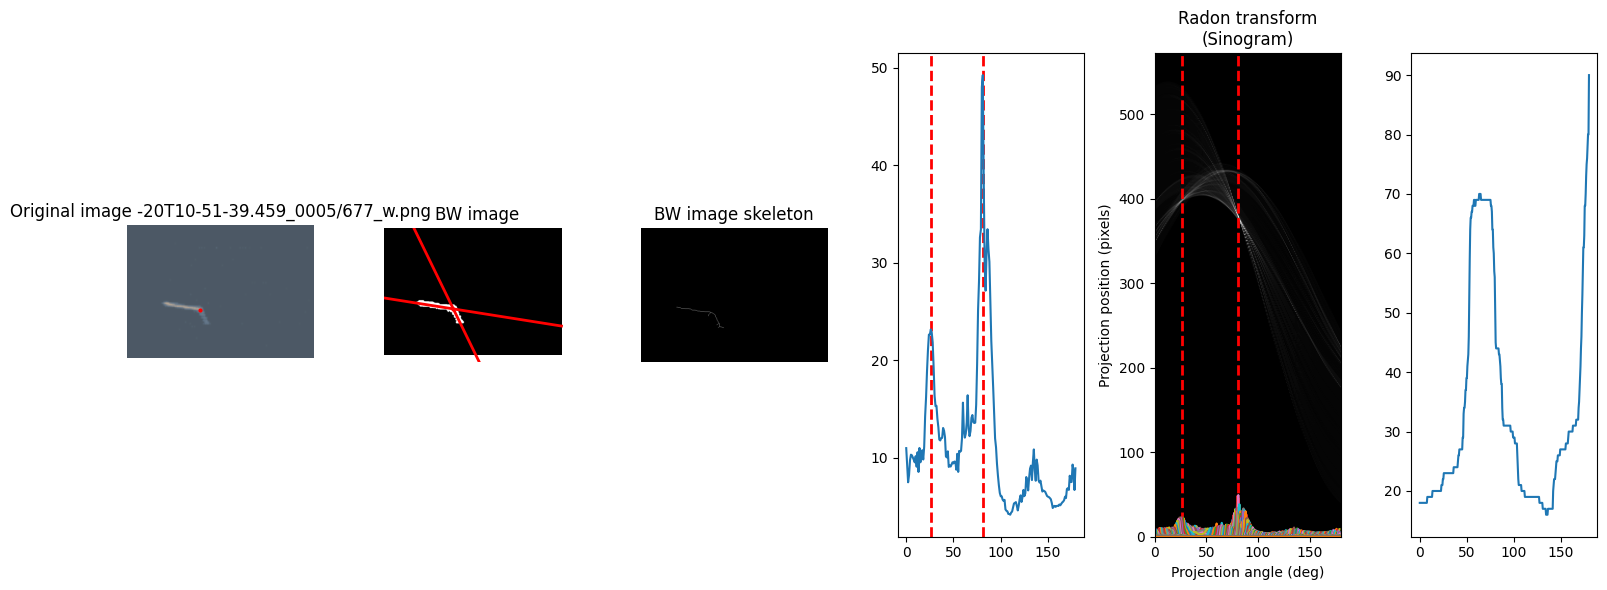

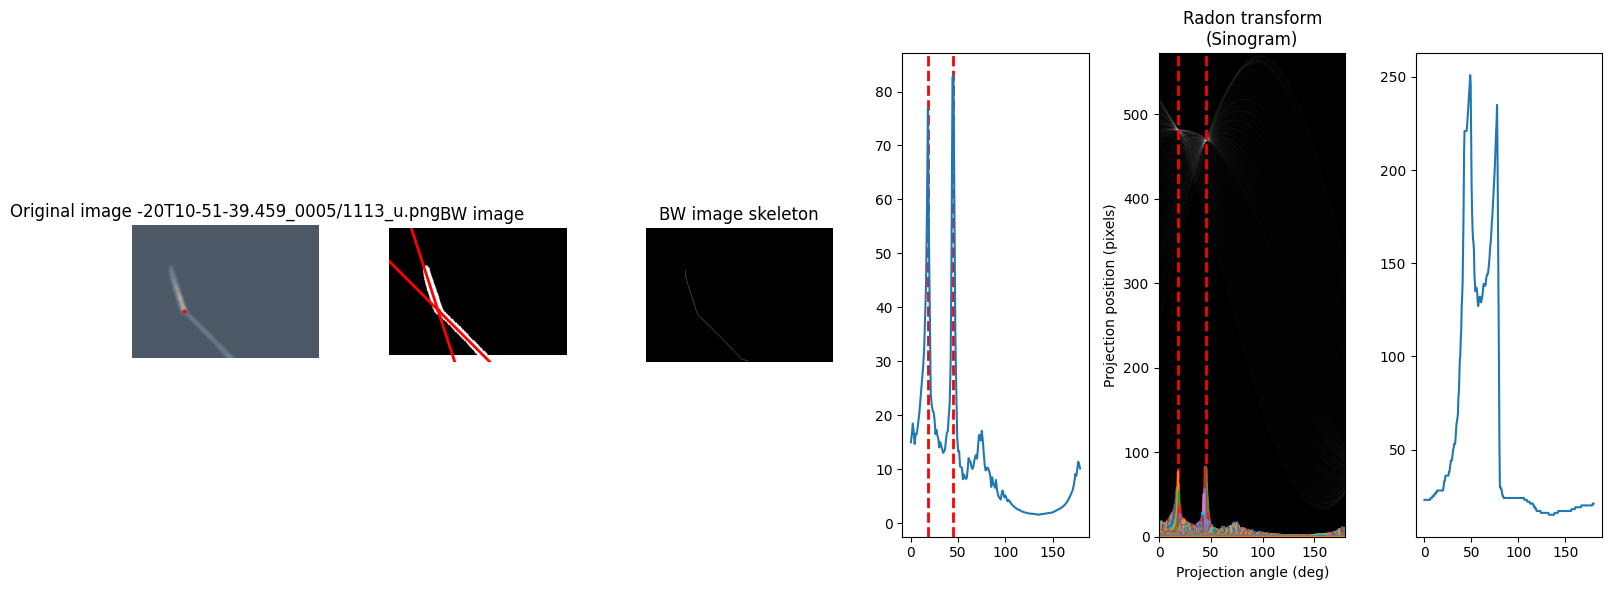

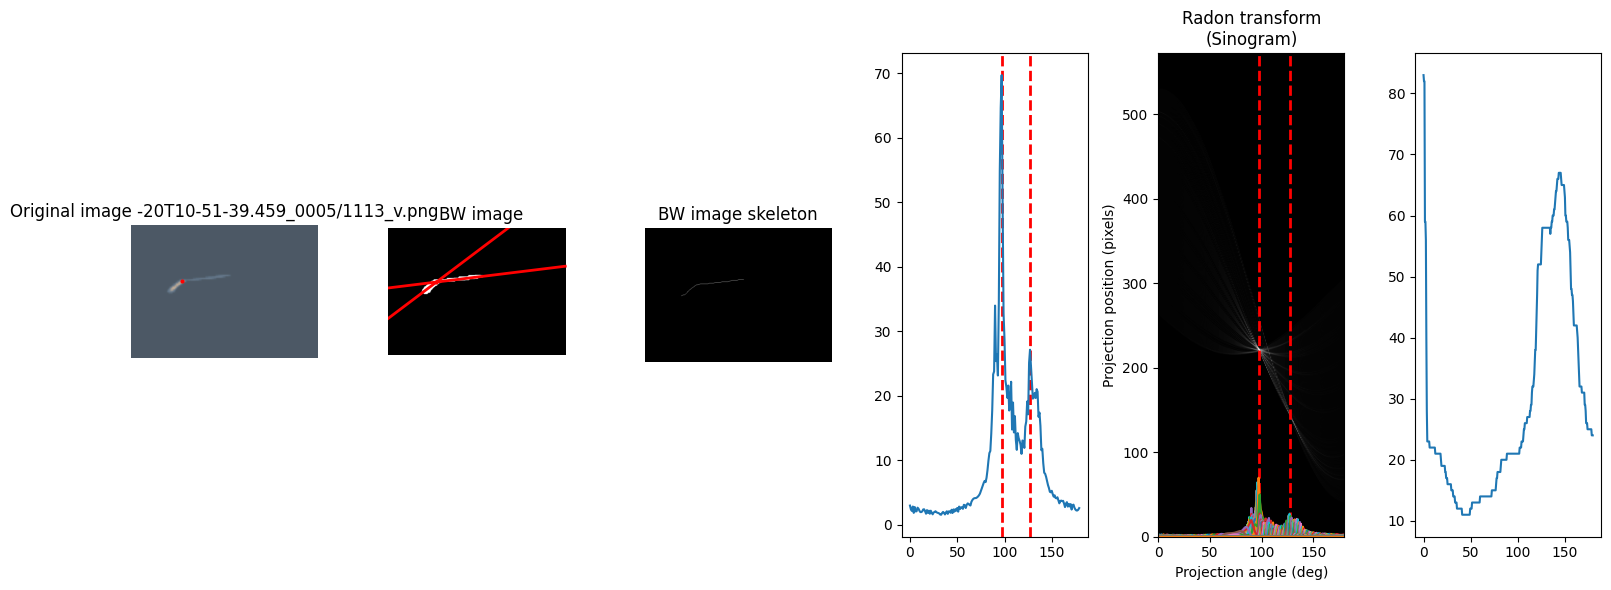

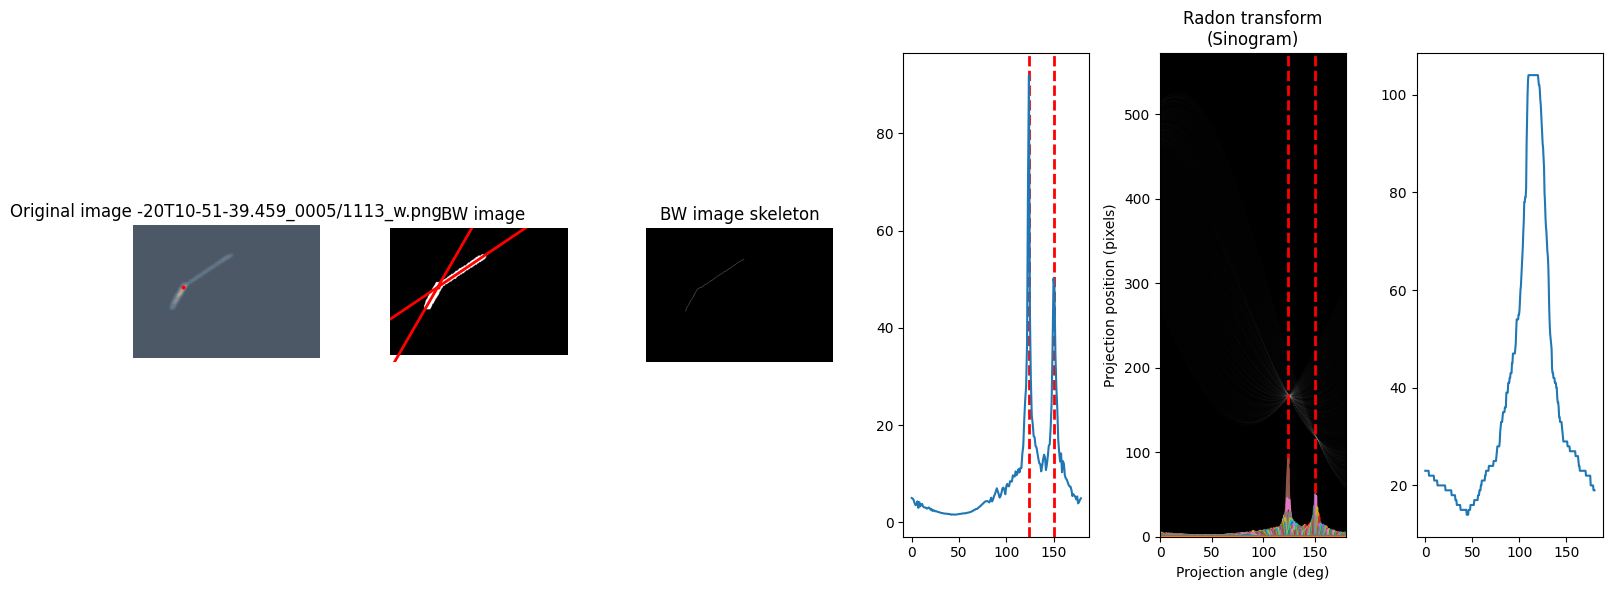

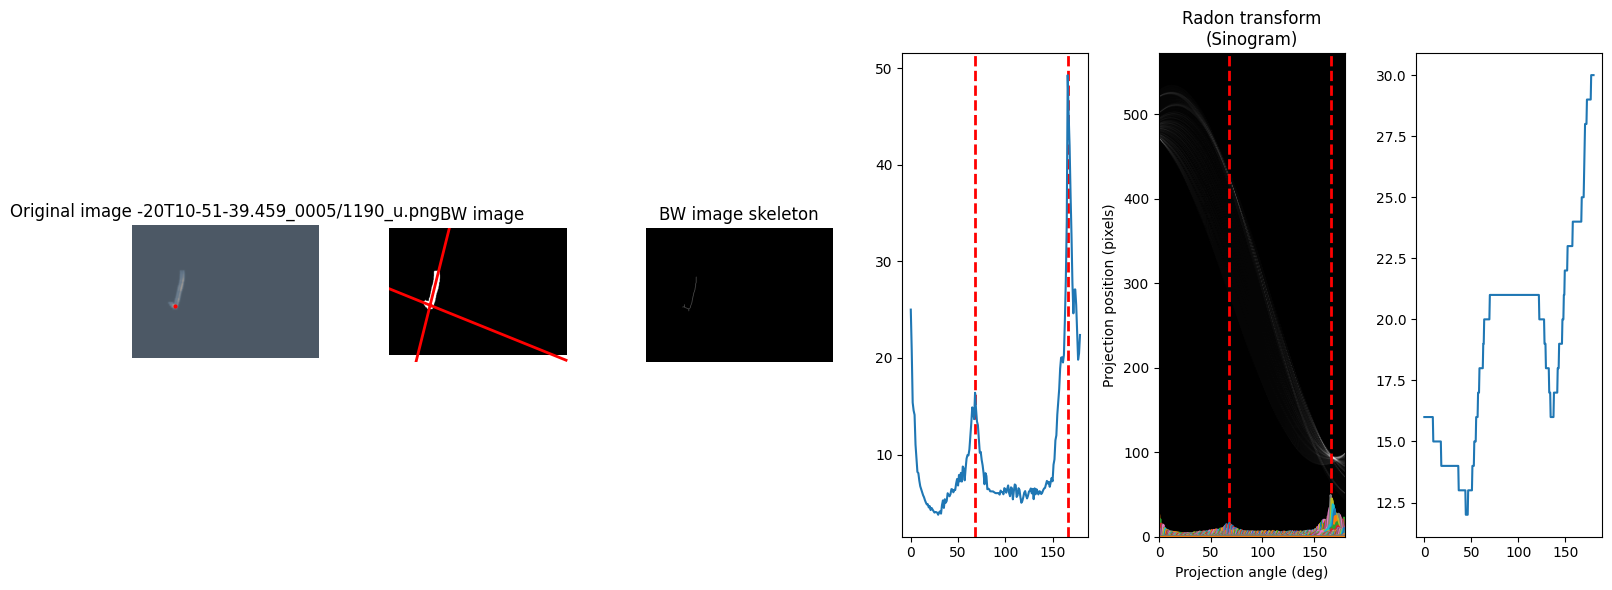

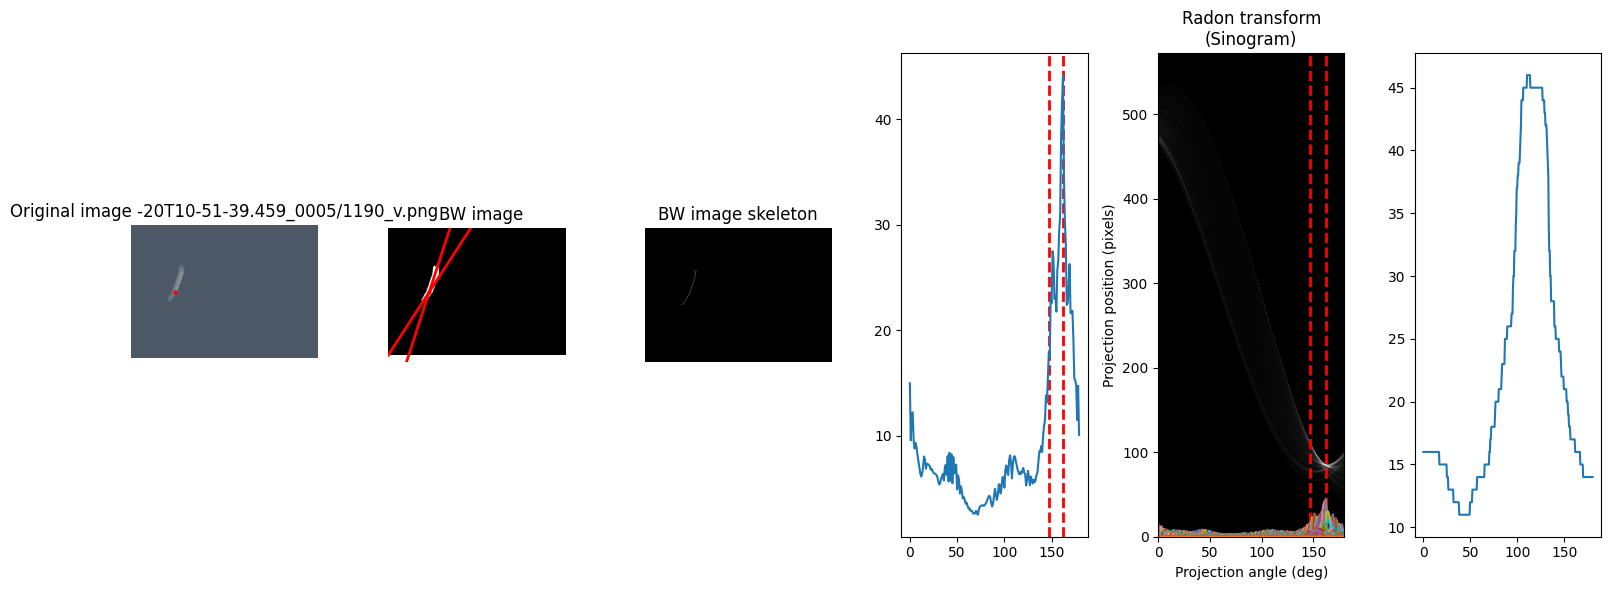

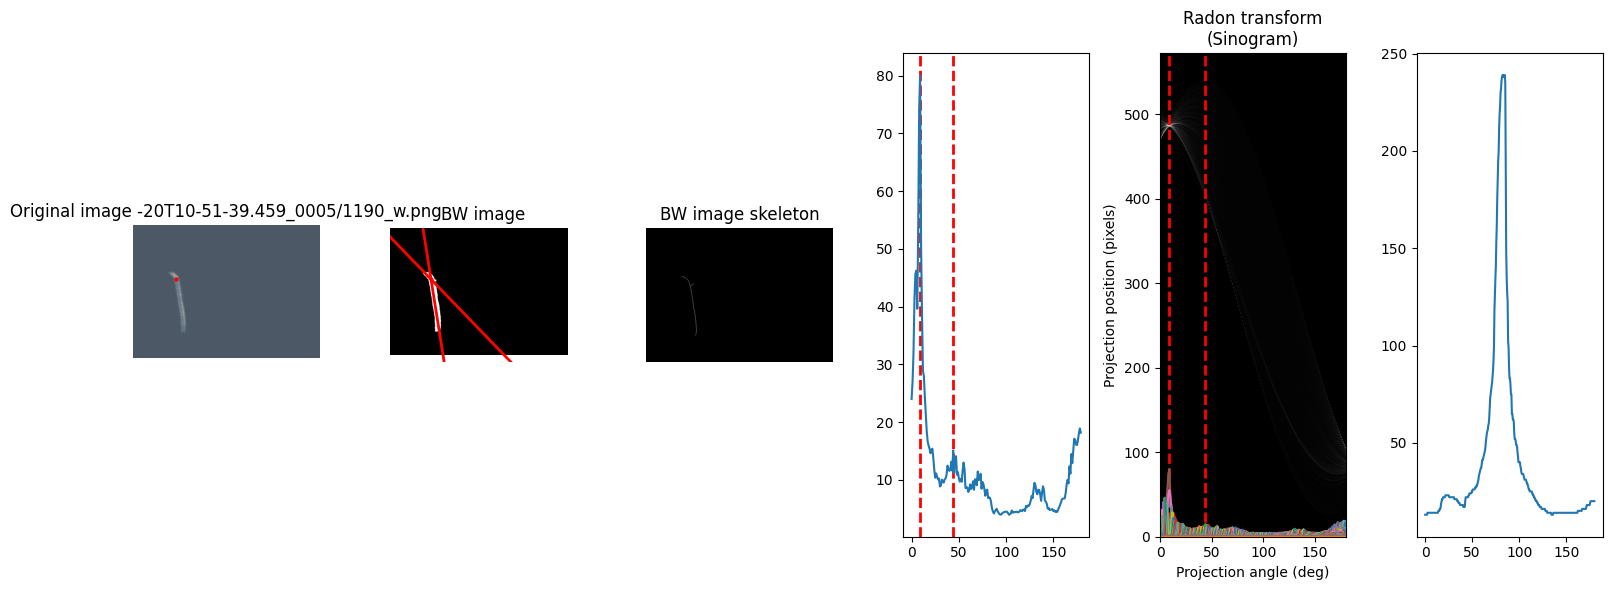

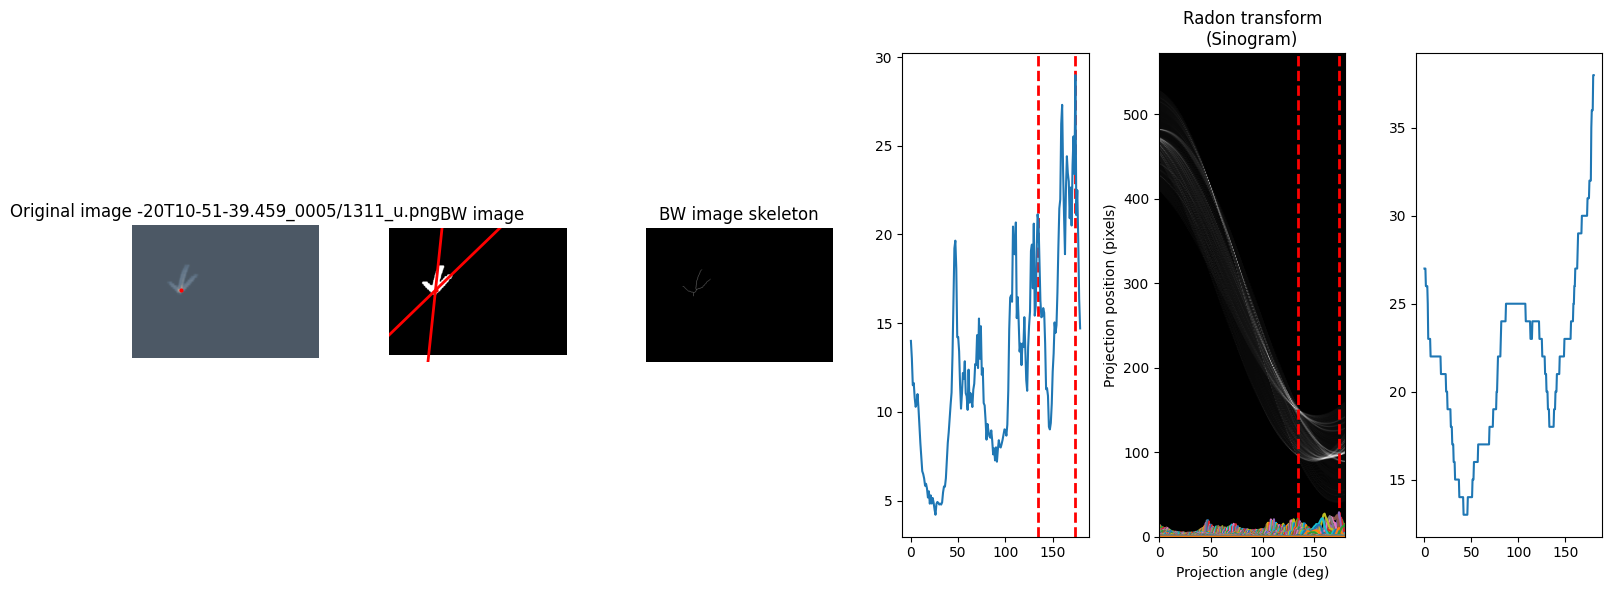

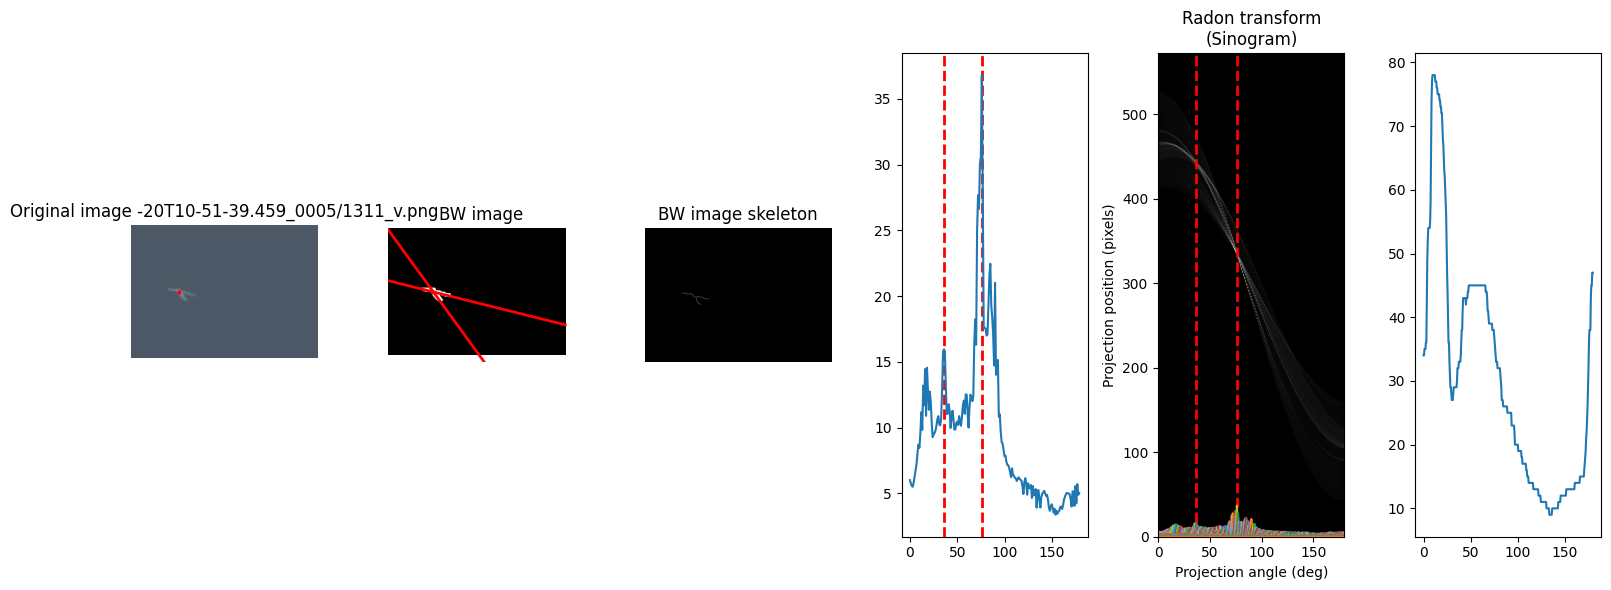

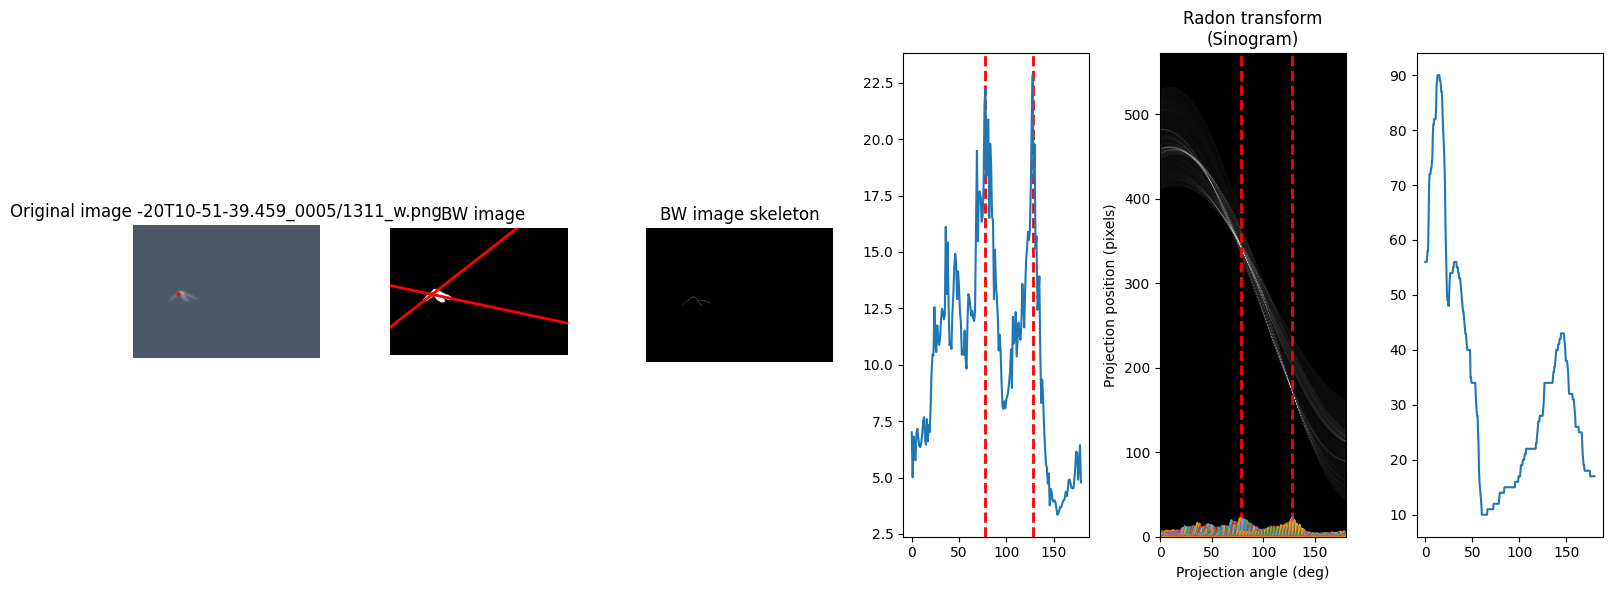

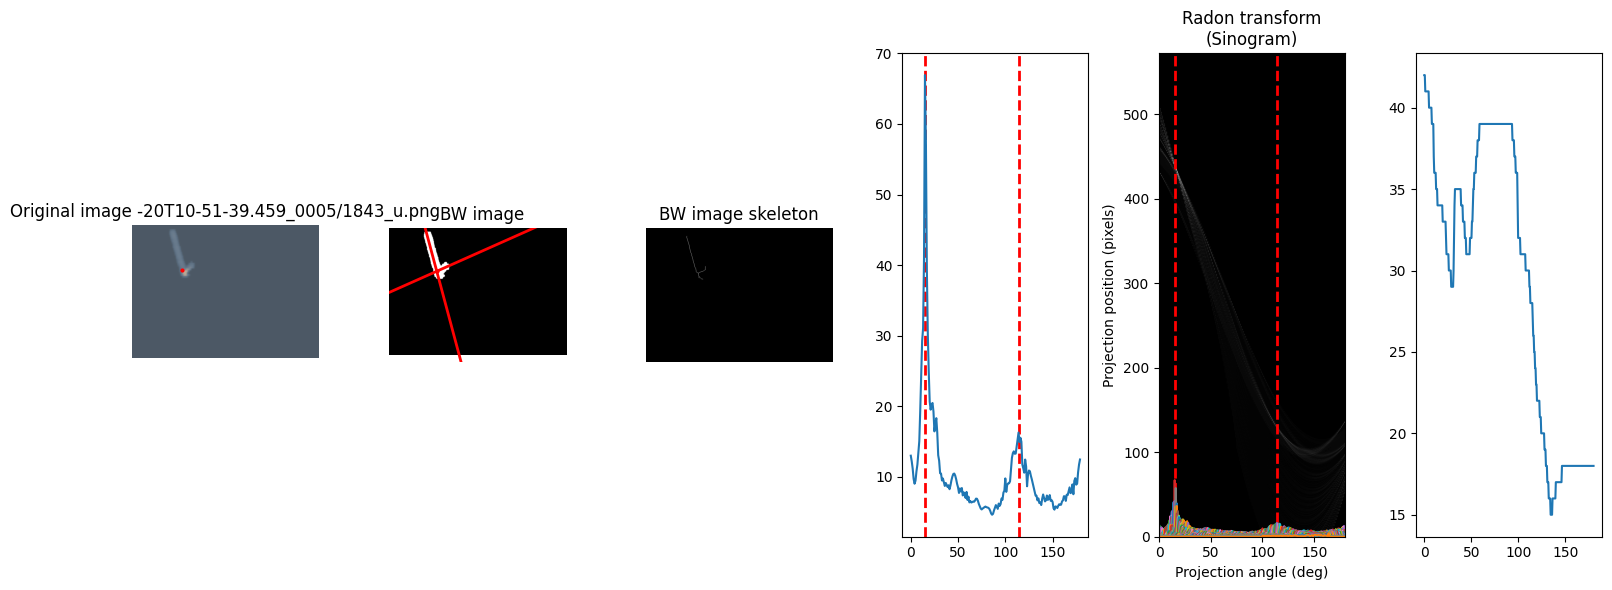

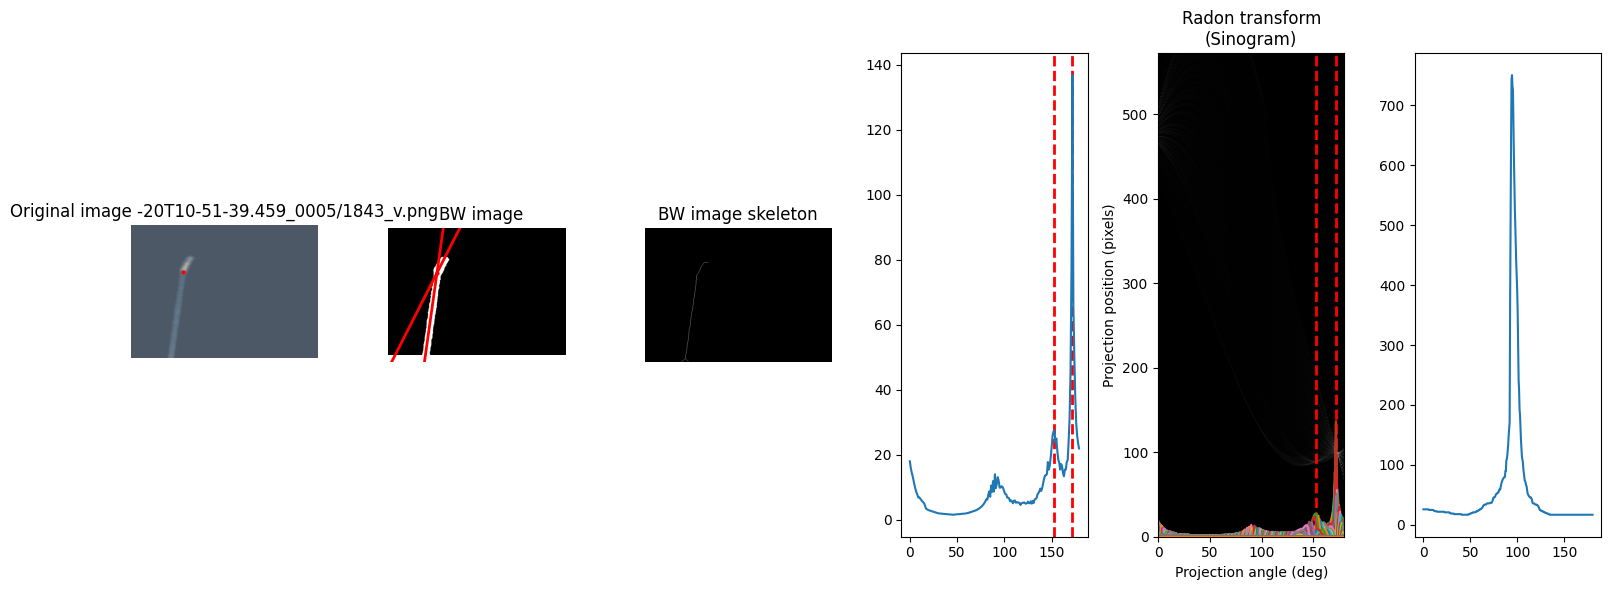

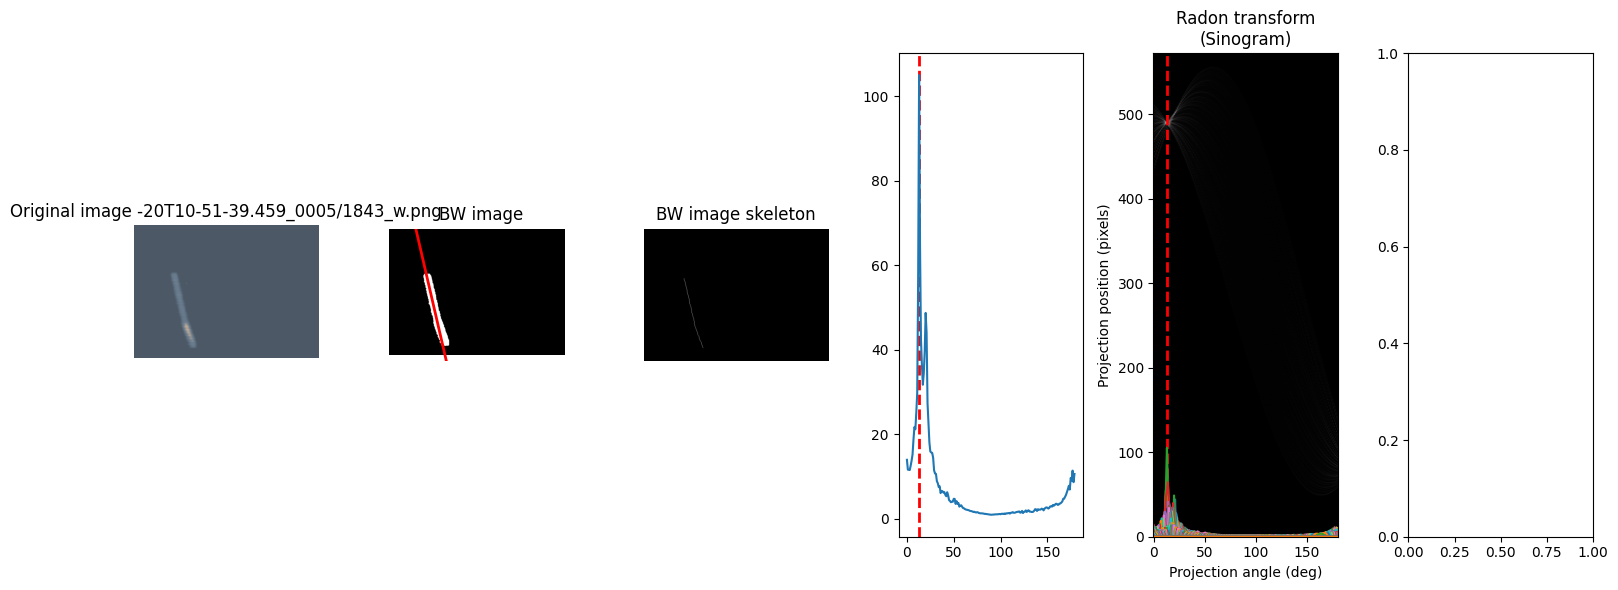

In [10]:
from matplotlib import cm
import numpy as np
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.morphology import skeletonize, binary_closing
from src.openImage import openImage

from skimage.transform import radon, rescale
from sklearn.cluster import KMeans

from scipy.signal import find_peaks
from skimage.draw import line


# Remove small shapes.
def cleanNoise(image, min_size_threshold=100):

    # Apply a different label for each shape.
    labeled_image, num_labels = ndimage.label(image)

    # Count the size of each labes which is the size of each shape. Remember to address the fact that 0 is not a real label and is background.
    sizes = np.bincount(labeled_image.ravel())

    # Exclude the background label (0) from the sizes array.
    sizes[0] = 0

    # Remove small connected components
    filtered_image = np.where(sizes[labeled_image] < min_size_threshold, 0, 1)

    return filtered_image


def computeRadon(image):

    max_shape = max(image.shape)

    # theta = np.linspace(0.0, 180.0, max_shape, endpoint=False)
    theta = np.arange(180)
    sinogram = radon(image, theta=theta)
    # sinogram = radon(image)
    dx, dy = 0.5 * 180.0 / max_shape, 0.5 / sinogram.shape[0]

    # The rows represent the angles.

    return dx, dy, sinogram


def filterPeaks(peaks, peak_array):

    lower_bound = 15
    upper_bound = 165

    # Get peaks within the bounds
    in_bounds_indices = np.where((peaks >= lower_bound) & (peaks <= upper_bound))[0]
    in_bounds_peaks = peaks[in_bounds_indices]

    # Get peaks outside the bounds
    out_of_bounds_indices = np.where((peaks < lower_bound) | (peaks > upper_bound))[0]
    out_of_bounds_peaks = peaks[out_of_bounds_indices]

    if len(out_of_bounds_peaks) > 0:
        # Get the peak with the highest height outside bounds
        out_of_bounds_heights = peak_array[out_of_bounds_peaks]
        max_height_index = np.argmax(out_of_bounds_heights)
        retained_peak = out_of_bounds_peaks[max_height_index]

        # Combine in-bounds peaks with the retained out-of-bounds peak
        filtered_peaks = np.concatenate((in_bounds_peaks, [retained_peak]))
    else:
        # If no out-of-bounds peaks, return only in-bounds peaks
        filtered_peaks = in_bounds_peaks

    return filtered_peaks


def findNPeaks(peak_array, num_peaks=3, peak_th=0.25, peak_distance=15):

    # Find all peaks
    peaks, properties = find_peaks(peak_array, distance=peak_distance)

    peaks = filterPeaks(peaks, peak_array)

    # Get peak heights
    peak_heights = peak_array[peaks]

    # Sort peaks by height (in descending order)
    sorted_indices = np.argsort(peak_heights)[::-1]

    # Get the largest peak height
    largest_peak_height = peak_heights[sorted_indices[0]]

    # Filter peaks that are at least peak_th*100% of the largest peak height
    valid_indices = sorted_indices[
        peak_heights[sorted_indices] >= peak_th * largest_peak_height
    ]

    # Limit the number of peaks to num_peaks
    top_peaks_indices = valid_indices[:num_peaks]

    # Get the x-axis locations of the top valid peaks
    top_peaks_x_locations = peaks[top_peaks_indices]

    return top_peaks_x_locations


def findPixelSpacing(width, height, num_rays):

    spacing = (min(width, height)) / (num_rays - 1)

    return spacing


def findNewIntegrals(image, point):

    height, width = image.shape
    x0, y0 = point
    angles = np.linspace(0, np.pi, 360)  # 360 different angles for precision

    # Helper function to get pixels along a line for a given angle
    def get_line_pixels(angle):
        # Find the direction of the line based on the angle
        x1 = int(x0 + 1000 * np.cos(angle))  # Extend far enough to cross the image
        y1 = int(y0 + 1000 * np.sin(angle))

        # Use skimage.draw.line to get the pixel coordinates for this line
        rr, cc = line(int(y0), int(x0), int(y1), int(x1))

        # Clip the points to be inside the image
        rr = np.clip(rr, 0, height - 1)
        cc = np.clip(cc, 0, width - 1)

        return rr, cc

    # Compute integral values for lines passing through the point
    integrals = []
    for angle in angles:
        rr, cc = get_line_pixels(angle)
        integral_value = np.sum(image[rr, cc])
        integrals.append((np.rad2deg(angle), integral_value))

    return integrals


def fitImage(path_and_name_input, path_and_name_output=None):

    ################### PARAMETERS TO BE CHANGED ###################

    white_th = 0.35  # 0.15
    gaussian_sigma = 1.75

    ##############################################################

    test_image = openImage(path_and_name_input)
    test_image.readImage()

    test_image.m_data = ndimage.gaussian_filter(test_image.m_data, gaussian_sigma)

    original_image = test_image.m_data

    # Black and white
    test_image.m_data = rgb2gray(test_image.m_data)

    grey_image = test_image.m_data

    # Turn completely black and white
    test_image.m_data = np.where(test_image.m_data < white_th, 0, 1)

    test_image.m_data = binary_closing(test_image.m_data, footprint=None)
    test_image.m_data = cleanNoise(test_image.m_data, 120)
    image_skelton = skeletonize(test_image.m_data)

    #####
    # image = rescale(test_image.m_data, scale=0.4, mode='reflect', channel_axis=None)
    #######

    # Create the canvas

    fig, axes = plt.subplots(1, 6, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(original_image)
    ax[0].set_title("Original image " + path_and_name_input[70:])
    ax[0].set_axis_off()
    ax[0].set_ylim(600, 0)

    ax[1].imshow(test_image.m_data, cmap=cm.gray)
    ax[1].set_title("BW image")
    ax[1].set_axis_off()
    ax[1].set_ylim(600, 0)

    ### Radon skeleton ###

    dx, dy, sinogram = computeRadon(image_skelton)

    ######################

    # print(sinogram.shape)

    max_proj = np.max(sinogram, axis=0)

    top2_peak_loc = findNPeaks(max_proj, 2, 0.15)

    # Get image dimensions
    rows, cols = test_image.m_data.shape
    center_x, center_y = cols // 2, rows // 2

    length = max(rows, cols)

    lines_eq = []

    for angle_deg in top2_peak_loc:

        # print(f"Angle: {angle_deg} with tan {np.tan(np.radians(angle_deg))} and corrected tan {np.tan(np.radians(90-angle_deg))}\n")

        # The slope of the line is the tangent of pi/2 - angle

        ax[3].axvline(x=angle_deg, color="r", linestyle="--", linewidth=2)
        ax[4].axvline(x=angle_deg, color="r", linestyle="--", linewidth=2)

        angle_rad = np.radians(angle_deg)

        ray_number = np.argmax(sinogram[:, angle_deg])

        num_lines, _ = sinogram.shape

        pixel_spacing = findPixelSpacing(rows, cols, num_lines)

        distance_center = (ray_number - (num_lines - 1) / 2) * pixel_spacing

        if angle_deg == 90:

            slope = 0
            intercept = center_y - distance_center

        elif angle_deg == 0:

            slope = 99  # np.inf
            intercept = center_x + distance_center

        else:

            slope = np.tan(np.radians(90 - angle_deg))
            intercept = center_y - slope * (
                center_x + distance_center / np.cos(angle_rad)
            )

        # print(f"Slope: {slope} Intercept: {intercept} Ray number: {ray_number}\n Pixel spacing: {pixel_spacing} Num lines: {num_lines} Distance center: {distance_center}\n")

        x_vals = np.array([0, length])

        y_vals = slope * x_vals + intercept

        ax[1].plot(x_vals, y_vals, "r-", lw=2)

        lines_eq.append([slope, intercept])

    # print("\n")

    ## Assume multiple intersections. Not good for this version but may be used later.
    # Calculate the intersection
    intersections = []

    for i, (slope1, intercept1) in enumerate(lines_eq):
        for slope2, intercept2 in lines_eq[i + 1 :]:
            if slope1 != slope2:  # Lines are not parallel
                x = (intercept2 - intercept1) / (slope1 - slope2)
                y = slope1 * x + intercept1
                if x > 0 and x < 800 and y > 0 and y < 600:
                    intersections.append((x, y))

    if len(intersections) != 0:
        average_x = sum(map(lambda point: point[0], intersections)) / len(intersections)
        average_y = sum(map(lambda point: point[1], intersections)) / len(intersections)

        ax[1].plot(average_x, average_y, marker="o", markersize=2, color="red")
        ax[0].plot(average_x, average_y, marker="o", markersize=2, color="red")

        # Find new best lines.
        new_integrals = findNewIntegrals(test_image.m_data, [average_x, average_y])

        angles, integral_values = zip(*new_integrals)

        ax[5].plot(angles, integral_values)

    ax[3].plot(max_proj)

    ax[2].imshow(image_skelton, cmap=cm.gray)
    ax[2].set_title("BW image skeleton")
    ax[2].set_axis_off()

    ax[4].set_title("Radon transform\n(Sinogram)")
    ax[4].set_xlabel("Projection angle (deg)")
    ax[4].set_ylabel("Projection position (pixels)")
    ax[4].imshow(
        sinogram,
        cmap=plt.cm.Greys_r,
        extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
        aspect="auto",
    )
    ax[4].plot(sinogram.T)

    plt.tight_layout()
    plt.savefig(path_and_name_output)


# approx. 87% 50/57
# approx. 94% 18/19 groups


image_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages2/"


image_list = [
    "CoBo_2018-06-20T10-51-39.459_0000/25",
    "CoBo_2018-06-20T10-51-39.459_0002/511",
    "CoBo_2018-06-20T10-51-39.459_0002/672",
    "CoBo_2018-06-20T10-51-39.459_0002/1019",
    "CoBo_2018-06-20T10-51-39.459_0003/1319",
    "CoBo_2018-06-20T10-51-39.459_0003/1428",
    "CoBo_2018-06-20T10-51-39.459_0004/114",
    "CoBo_2018-06-20T10-51-39.459_0004/319",
    "CoBo_2018-06-20T10-51-39.459_0004/417",
    "CoBo_2018-06-20T10-51-39.459_0004/448",
    "CoBo_2018-06-20T10-51-39.459_0004/1456",
    "CoBo_2018-06-20T10-51-39.459_0004/1596",
    "CoBo_2018-06-20T10-51-39.459_0004/1725",
    "CoBo_2018-06-20T10-51-39.459_0005/477",
    "CoBo_2018-06-20T10-51-39.459_0005/677",
    "CoBo_2018-06-20T10-51-39.459_0005/1113",
    "CoBo_2018-06-20T10-51-39.459_0005/1190",
    "CoBo_2018-06-20T10-51-39.459_0005/1311",
    "CoBo_2018-06-20T10-51-39.459_0005/1843",
]
# image_list = ["CoBo_2018-06-20T10-51-39.459_0000/25"] # Default test
# image_list = ["CoBo_2018-06-20T10-51-39.459_0004/114"] # Horizontal line
# image_list = ["CoBo_2018-06-20T10-51-39.459_0005/477"] # Peaks at both ends of the angle array
# image_list = ["CoBo_2018-06-20T10-51-39.459_0005/1113"]


image_suffix_list = ["_u.png", "_v.png", "_w.png"]


output_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/fittedimages_radon/"


for image in image_list:
    for suffix in image_suffix_list:
        fitImage((image_path + image + suffix), (output_path + image + suffix))